In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.ticker as ticker
import matplotlib.pylab as pl
from itertools import cycle
import matplotlib.gridspec as gridspec
import glob
import collections
import math
import re
import os
from collections import defaultdict
import string
from matplotlib.ticker import FormatStrFormatter

plt.rcParams["font.family"] = "Times New Roman"
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)

This notebook is used to plot the shannon calculations obtained from the multispecies_shannon_calculator code.


In [2]:
def getEventCountersDataframe(date, pc_res, phase, sigma, duration):
    
    return pd.read_csv("geno_distb_data_"+phase+"/"+str(pc_res)+"_resistant-"+date+"/"+str(pc_res)+"_resistant-"+date+"-event_counters-sigma="+"{:.5f}".format(sigma)+"-t="+str(duration)+".0.csv")


In [3]:
g_max = 0.083
nRuns = 100
nRuns_list = [r for r in range(nRuns)]
dates = ["24-Sep-2020", "09-Oct-2020", "14-Oct-2020", "06-Nov-2020", "16-Nov-2020", "25-Nov-2020", "03-Dec-2020", "18-Dec-2020",
         "06-Jan-2021", "11-Jan-2021", "12-Jan-2021"]
duration = 4368 #duration of sims in hours - equivalent to 26 weeks
pc_res_vals = [14, 15, 16] #percentages of the population which have an innante resistance to the biocide
phase2_str = "phase2"
log_norm_params_14pcRes = [2.703747953786337, 0.5690825284230452]
log_norm_params_15pcRes = [2.6133256846855746, 0.6260058161550592]
log_norm_params_16pcRes = [2.47772924764521, 0.7060073500033884]



#event counters dataframes
event_counters_14pc_24Sep = getEventCountersDataframe(dates[0], pc_res_vals[0], phase2_str, log_norm_params_14pcRes[1], duration)
event_counters_15pc_24Sep = getEventCountersDataframe(dates[0], pc_res_vals[1], phase2_str, log_norm_params_15pcRes[1], duration)
event_counters_16pc_24Sep = getEventCountersDataframe(dates[0], pc_res_vals[2], phase2_str, log_norm_params_16pcRes[1], duration)

event_counters_14pc_09Oct = getEventCountersDataframe(dates[1], pc_res_vals[0], phase2_str, log_norm_params_14pcRes[1], duration)
event_counters_15pc_09Oct = getEventCountersDataframe(dates[1], pc_res_vals[1], phase2_str, log_norm_params_15pcRes[1], duration)
event_counters_16pc_09Oct = getEventCountersDataframe(dates[1], pc_res_vals[2], phase2_str, log_norm_params_16pcRes[1], duration)

event_counters_14pc_14Oct = getEventCountersDataframe(dates[2], pc_res_vals[0], phase2_str, log_norm_params_14pcRes[1], duration)
event_counters_15pc_14Oct = getEventCountersDataframe(dates[2], pc_res_vals[1], phase2_str, log_norm_params_15pcRes[1], duration)
event_counters_16pc_14Oct = getEventCountersDataframe(dates[2], pc_res_vals[2], phase2_str, log_norm_params_16pcRes[1], duration)

event_counters_14pc_06Nov = getEventCountersDataframe(dates[3], pc_res_vals[0], phase2_str, log_norm_params_14pcRes[1], duration)
event_counters_15pc_06Nov = getEventCountersDataframe(dates[3], pc_res_vals[1], phase2_str, log_norm_params_15pcRes[1], duration)
event_counters_16pc_06Nov = getEventCountersDataframe(dates[3], pc_res_vals[2], phase2_str, log_norm_params_16pcRes[1], duration)

event_counters_14pc_16Nov = getEventCountersDataframe(dates[4], pc_res_vals[0], phase2_str, log_norm_params_14pcRes[1], duration)
event_counters_15pc_16Nov = getEventCountersDataframe(dates[4], pc_res_vals[1], phase2_str, log_norm_params_15pcRes[1], duration)
event_counters_16pc_16Nov = getEventCountersDataframe(dates[4], pc_res_vals[2], phase2_str, log_norm_params_16pcRes[1], duration)

event_counters_14pc_25Nov = getEventCountersDataframe(dates[5], pc_res_vals[0], phase2_str, log_norm_params_14pcRes[1], duration)
event_counters_15pc_25Nov = getEventCountersDataframe(dates[5], pc_res_vals[1], phase2_str, log_norm_params_15pcRes[1], duration)
event_counters_16pc_25Nov = getEventCountersDataframe(dates[5], pc_res_vals[2], phase2_str, log_norm_params_16pcRes[1], duration)

event_counters_14pc_03Dec = getEventCountersDataframe(dates[6], pc_res_vals[0], phase2_str, log_norm_params_14pcRes[1], duration)
event_counters_15pc_03Dec = getEventCountersDataframe(dates[6], pc_res_vals[1], phase2_str, log_norm_params_15pcRes[1], duration)
event_counters_16pc_03Dec = getEventCountersDataframe(dates[6], pc_res_vals[2], phase2_str, log_norm_params_16pcRes[1], duration)

event_counters_14pc_18Dec = getEventCountersDataframe(dates[7], pc_res_vals[0], phase2_str, log_norm_params_14pcRes[1], duration)
event_counters_15pc_18Dec = getEventCountersDataframe(dates[7], pc_res_vals[1], phase2_str, log_norm_params_15pcRes[1], duration)
event_counters_16pc_18Dec = getEventCountersDataframe(dates[7], pc_res_vals[2], phase2_str, log_norm_params_16pcRes[1], duration)

event_counters_15pc_06Jan = getEventCountersDataframe(dates[8], pc_res_vals[1], phase2_str, log_norm_params_15pcRes[1], duration)
event_counters_16pc_06Jan = getEventCountersDataframe(dates[8], pc_res_vals[2], phase2_str, log_norm_params_16pcRes[1], duration)

event_counters_15pc_11Jan = getEventCountersDataframe(dates[9], pc_res_vals[1], phase2_str, log_norm_params_15pcRes[1], duration)
event_counters_16pc_11Jan = getEventCountersDataframe(dates[9], pc_res_vals[2], phase2_str, log_norm_params_16pcRes[1], duration)

event_counters_15pc_12Jan = getEventCountersDataframe(dates[10], pc_res_vals[1], phase2_str, log_norm_params_15pcRes[1], duration)
event_counters_16pc_12Jan = getEventCountersDataframe(dates[10], pc_res_vals[2], phase2_str, log_norm_params_16pcRes[1], duration)


#paths to the directories containing all the processed shannon data csv files
shannon_directory_14pc_24Sep = "shannon_calculations_phase2/14_pc_res-24-Sep-2020/" 
shannon_directory_15pc_24Sep = "shannon_calculations_phase2/15_pc_res-24-Sep-2020/"

#paths to the directories containing the processed shannon data csv files for runs which exhibited GROWTH
shannon_directory_14pc_24Sep_GROWTH = "shannon_calculations_phase2_GROWTH/14_pc_res-24-Sep-2020/"
shannon_directory_15pc_24Sep_GROWTH = "shannon_calculations_phase2_GROWTH/15_pc_res-24-Sep-2020/"
shannon_directory_16pc_24Sep_GROWTH = "shannon_calculations_phase2_GROWTH/16_pc_res-24-Sep-2020/"

shannon_directory_14pc_09Oct_GROWTH = "shannon_calculations_phase2_GROWTH/14_pc_res-09-Oct-2020/"
shannon_directory_15pc_09Oct_GROWTH = "shannon_calculations_phase2_GROWTH/15_pc_res-09-Oct-2020/"
shannon_directory_16pc_09Oct_GROWTH = "shannon_calculations_phase2_GROWTH/16_pc_res-09-Oct-2020/"

shannon_directory_14pc_14Oct_GROWTH = "shannon_calculations_phase2_GROWTH/14_pc_res-14-Oct-2020/"
shannon_directory_15pc_14Oct_GROWTH = "shannon_calculations_phase2_GROWTH/15_pc_res-14-Oct-2020/"
shannon_directory_16pc_14Oct_GROWTH = "shannon_calculations_phase2_GROWTH/16_pc_res-14-Oct-2020/"

shannon_directory_14pc_06Nov_GROWTH = "shannon_calculations_phase2_GROWTH/14_pc_res-06-Nov-2020/"
shannon_directory_15pc_06Nov_GROWTH = "shannon_calculations_phase2_GROWTH/15_pc_res-06-Nov-2020/"
shannon_directory_16pc_06Nov_GROWTH = "shannon_calculations_phase2_GROWTH/16_pc_res-06-Nov-2020/"

shannon_directory_14pc_16Nov_GROWTH = "shannon_calculations_phase2_GROWTH/14_pc_res-16-Nov-2020/"
shannon_directory_15pc_16Nov_GROWTH = "shannon_calculations_phase2_GROWTH/15_pc_res-16-Nov-2020/"
shannon_directory_16pc_16Nov_GROWTH = "shannon_calculations_phase2_GROWTH/16_pc_res-16-Nov-2020/"

shannon_directory_14pc_25Nov_GROWTH = "shannon_calculations_phase2_GROWTH/14_pc_res-25-Nov-2020/"
shannon_directory_15pc_25Nov_GROWTH = "shannon_calculations_phase2_GROWTH/15_pc_res-25-Nov-2020/"
shannon_directory_16pc_25Nov_GROWTH = "shannon_calculations_phase2_GROWTH/16_pc_res-25-Nov-2020/"

shannon_directory_14pc_03Dec_GROWTH = "shannon_calculations_phase2_GROWTH/14_pc_res-03-Dec-2020/"
shannon_directory_15pc_03Dec_GROWTH = "shannon_calculations_phase2_GROWTH/15_pc_res-03-Dec-2020/"
shannon_directory_16pc_03Dec_GROWTH = "shannon_calculations_phase2_GROWTH/16_pc_res-03-Dec-2020/"

shannon_directory_14pc_18Dec_GROWTH = "shannon_calculations_phase2_GROWTH/14_pc_res-18-Dec-2020/"
shannon_directory_15pc_18Dec_GROWTH = "shannon_calculations_phase2_GROWTH/15_pc_res-18-Dec-2020/"
shannon_directory_16pc_18Dec_GROWTH = "shannon_calculations_phase2_GROWTH/16_pc_res-18-Dec-2020/"

# 14% resistant has 1100 runs at this point so focusing on 15/16% for the time being
shannon_directory_15pc_06Jan_GROWTH = "shannon_calculations_phase2_GROWTH/15_pc_res-06-Jan-2021/"
shannon_directory_16pc_06Jan_GROWTH = "shannon_calculations_phase2_GROWTH/16_pc_res-06-Jan-2021/"

shannon_directory_15pc_11Jan_GROWTH = "shannon_calculations_phase2_GROWTH/15_pc_res-11-Jan-2021/"
shannon_directory_16pc_11Jan_GROWTH = "shannon_calculations_phase2_GROWTH/16_pc_res-11-Jan-2021/"

shannon_directory_15pc_12Jan_GROWTH = "shannon_calculations_phase2_GROWTH/15_pc_res-12-Jan-2021/"
shannon_directory_16pc_12Jan_GROWTH = "shannon_calculations_phase2_GROWTH/16_pc_res-12-Jan-2021/"


#paths to the directories containing the processed shannon data csv files for runs which exhibited NOGROWTH
shannon_directory_14pc_24Sep_NOGROWTH = "shannon_calculations_phase2_NOGROWTH/14_pc_res-24-Sep-2020/"
shannon_directory_15pc_24Sep_NOGROWTH = "shannon_calculations_phase2_NOGROWTH/15_pc_res-24-Sep-2020/"
shannon_directory_16pc_24Sep_NOGROWTH = "shannon_calculations_phase2_NOGROWTH/16_pc_res-24-Sep-2020/"

shannon_directory_14pc_09Oct_NOGROWTH = "shannon_calculations_phase2_NOGROWTH/14_pc_res-09-Oct-2020/"
shannon_directory_15pc_09Oct_NOGROWTH = "shannon_calculations_phase2_NOGROWTH/15_pc_res-09-Oct-2020/"
shannon_directory_16pc_09Oct_NOGROWTH = "shannon_calculations_phase2_NOGROWTH/16_pc_res-09-Oct-2020/"

shannon_directory_14pc_14Oct_NOGROWTH = "shannon_calculations_phase2_NOGROWTH/14_pc_res-14-Oct-2020/"
shannon_directory_15pc_14Oct_NOGROWTH = "shannon_calculations_phase2_NOGROWTH/15_pc_res-14-Oct-2020/"
shannon_directory_16pc_14Oct_NOGROWTH = "shannon_calculations_phase2_NOGROWTH/16_pc_res-14-Oct-2020/"

shannon_directory_14pc_06Nov_NOGROWTH = "shannon_calculations_phase2_NOGROWTH/14_pc_res-06-Nov-2020/"
shannon_directory_15pc_06Nov_NOGROWTH = "shannon_calculations_phase2_NOGROWTH/15_pc_res-06-Nov-2020/"
shannon_directory_16pc_06Nov_NOGROWTH = "shannon_calculations_phase2_NOGROWTH/16_pc_res-06-Nov-2020/"

shannon_directory_14pc_16Nov_NOGROWTH = "shannon_calculations_phase2_NOGROWTH/14_pc_res-16-Nov-2020/"
shannon_directory_15pc_16Nov_NOGROWTH = "shannon_calculations_phase2_NOGROWTH/15_pc_res-16-Nov-2020/"
shannon_directory_16pc_16Nov_NOGROWTH = "shannon_calculations_phase2_NOGROWTH/16_pc_res-16-Nov-2020/"

shannon_directory_14pc_25Nov_NOGROWTH = "shannon_calculations_phase2_NOGROWTH/14_pc_res-25-Nov-2020/"
shannon_directory_15pc_25Nov_NOGROWTH = "shannon_calculations_phase2_NOGROWTH/15_pc_res-25-Nov-2020/"
shannon_directory_16pc_25Nov_NOGROWTH = "shannon_calculations_phase2_NOGROWTH/16_pc_res-25-Nov-2020/"

shannon_directory_14pc_03Dec_NOGROWTH = "shannon_calculations_phase2_NOGROWTH/14_pc_res-03-Dec-2020/"
shannon_directory_15pc_03Dec_NOGROWTH = "shannon_calculations_phase2_NOGROWTH/15_pc_res-03-Dec-2020/"
shannon_directory_16pc_03Dec_NOGROWTH = "shannon_calculations_phase2_NOGROWTH/16_pc_res-03-Dec-2020/"

shannon_directory_14pc_18Dec_NOGROWTH = "shannon_calculations_phase2_NOGROWTH/14_pc_res-18-Dec-2020/"
shannon_directory_15pc_18Dec_NOGROWTH = "shannon_calculations_phase2_NOGROWTH/15_pc_res-18-Dec-2020/"
shannon_directory_16pc_18Dec_NOGROWTH = "shannon_calculations_phase2_NOGROWTH/16_pc_res-18-Dec-2020/"

shannon_directory_15pc_06Jan_NOGROWTH = "shannon_calculations_phase2_NOGROWTH/15_pc_res-06-Jan-2021/"
shannon_directory_16pc_06Jan_NOGROWTH = "shannon_calculations_phase2_NOGROWTH/16_pc_res-06-Jan-2021/"

shannon_directory_15pc_11Jan_NOGROWTH = "shannon_calculations_phase2_NOGROWTH/15_pc_res-11-Jan-2021/"
shannon_directory_16pc_11Jan_NOGROWTH = "shannon_calculations_phase2_NOGROWTH/16_pc_res-11-Jan-2021/"

shannon_directory_15pc_12Jan_NOGROWTH = "shannon_calculations_phase2_NOGROWTH/15_pc_res-12-Jan-2021/"
shannon_directory_16pc_12Jan_NOGROWTH = "shannon_calculations_phase2_NOGROWTH/16_pc_res-12-Jan-2021/"



#paths to the directories containing the processed shannon data csv files for the EDGE microhabitats for runs which exhibited GROWTH
shannon_directory_14pc_24Sep_GROWTH_EDGE = "shannon_calculations_phase2_GROWTH_EDGE/14_pc_res-24-Sep-2020_GROWTH_EDGE/"
shannon_directory_15pc_24Sep_GROWTH_EDGE = "shannon_calculations_phase2_GROWTH_EDGE/15_pc_res-24-Sep-2020_GROWTH_EDGE/"
shannon_directory_16pc_24Sep_GROWTH_EDGE = "shannon_calculations_phase2_GROWTH_EDGE/16_pc_res-24-Sep-2020_GROWTH_EDGE/"

shannon_directory_14pc_09Oct_GROWTH_EDGE = "shannon_calculations_phase2_GROWTH_EDGE/14_pc_res-09-Oct-2020_GROWTH_EDGE/"
shannon_directory_15pc_09Oct_GROWTH_EDGE = "shannon_calculations_phase2_GROWTH_EDGE/15_pc_res-09-Oct-2020_GROWTH_EDGE/"
shannon_directory_16pc_09Oct_GROWTH_EDGE = "shannon_calculations_phase2_GROWTH_EDGE/16_pc_res-09-Oct-2020_GROWTH_EDGE/"

shannon_directory_14pc_14Oct_GROWTH_EDGE = "shannon_calculations_phase2_GROWTH_EDGE/14_pc_res-14-Oct-2020_GROWTH_EDGE/"
shannon_directory_15pc_14Oct_GROWTH_EDGE = "shannon_calculations_phase2_GROWTH_EDGE/15_pc_res-14-Oct-2020_GROWTH_EDGE/"
shannon_directory_16pc_14Oct_GROWTH_EDGE = "shannon_calculations_phase2_GROWTH_EDGE/16_pc_res-14-Oct-2020_GROWTH_EDGE/"

shannon_directory_14pc_06Nov_GROWTH_EDGE = "shannon_calculations_phase2_GROWTH_EDGE/14_pc_res-06-Nov-2020_GROWTH_EDGE/"
shannon_directory_15pc_06Nov_GROWTH_EDGE = "shannon_calculations_phase2_GROWTH_EDGE/15_pc_res-06-Nov-2020_GROWTH_EDGE/"
shannon_directory_16pc_06Nov_GROWTH_EDGE = "shannon_calculations_phase2_GROWTH_EDGE/16_pc_res-06-Nov-2020_GROWTH_EDGE/"

shannon_directory_14pc_16Nov_GROWTH_EDGE = "shannon_calculations_phase2_GROWTH_EDGE/14_pc_res-16-Nov-2020_GROWTH_EDGE/"
shannon_directory_15pc_16Nov_GROWTH_EDGE = "shannon_calculations_phase2_GROWTH_EDGE/15_pc_res-16-Nov-2020_GROWTH_EDGE/"
shannon_directory_16pc_16Nov_GROWTH_EDGE = "shannon_calculations_phase2_GROWTH_EDGE/16_pc_res-16-Nov-2020_GROWTH_EDGE/"

shannon_directory_14pc_25Nov_GROWTH_EDGE = "shannon_calculations_phase2_GROWTH_EDGE/14_pc_res-25-Nov-2020_GROWTH_EDGE/"
shannon_directory_15pc_25Nov_GROWTH_EDGE = "shannon_calculations_phase2_GROWTH_EDGE/15_pc_res-25-Nov-2020_GROWTH_EDGE/"
shannon_directory_16pc_25Nov_GROWTH_EDGE = "shannon_calculations_phase2_GROWTH_EDGE/16_pc_res-25-Nov-2020_GROWTH_EDGE/"

shannon_directory_14pc_03Dec_GROWTH_EDGE = "shannon_calculations_phase2_GROWTH_EDGE/14_pc_res-03-Dec-2020_GROWTH_EDGE/"
shannon_directory_15pc_03Dec_GROWTH_EDGE = "shannon_calculations_phase2_GROWTH_EDGE/15_pc_res-03-Dec-2020_GROWTH_EDGE/"
shannon_directory_16pc_03Dec_GROWTH_EDGE = "shannon_calculations_phase2_GROWTH_EDGE/16_pc_res-03-Dec-2020_GROWTH_EDGE/"

shannon_directory_14pc_18Dec_GROWTH_EDGE = "shannon_calculations_phase2_GROWTH_EDGE/14_pc_res-18-Dec-2020_GROWTH_EDGE/"
shannon_directory_15pc_18Dec_GROWTH_EDGE = "shannon_calculations_phase2_GROWTH_EDGE/15_pc_res-18-Dec-2020_GROWTH_EDGE/"
shannon_directory_16pc_18Dec_GROWTH_EDGE = "shannon_calculations_phase2_GROWTH_EDGE/16_pc_res-18-Dec-2020_GROWTH_EDGE/"

shannon_directory_15pc_06Jan_GROWTH_EDGE = "shannon_calculations_phase2_GROWTH_EDGE/15_pc_res-06-Jan-2021_GROWTH_EDGE/"
shannon_directory_16pc_06Jan_GROWTH_EDGE = "shannon_calculations_phase2_GROWTH_EDGE/16_pc_res-06-Jan-2021_GROWTH_EDGE/"

shannon_directory_15pc_11Jan_GROWTH_EDGE = "shannon_calculations_phase2_GROWTH_EDGE/15_pc_res-11-Jan-2021_GROWTH_EDGE/"
shannon_directory_16pc_11Jan_GROWTH_EDGE = "shannon_calculations_phase2_GROWTH_EDGE/16_pc_res-11-Jan-2021_GROWTH_EDGE/"

shannon_directory_15pc_12Jan_GROWTH_EDGE = "shannon_calculations_phase2_GROWTH_EDGE/15_pc_res-12-Jan-2021_GROWTH_EDGE/"
shannon_directory_16pc_12Jan_GROWTH_EDGE = "shannon_calculations_phase2_GROWTH_EDGE/16_pc_res-12-Jan-2021_GROWTH_EDGE/"

In [4]:
#paths to the directories containing the processed shannon data csv files for the CORE microhabitats for runs which exhibited GROWTH
shannon_directory_14pc_24Sep_GROWTH_CORE = "shannon_calculations_phase2_GROWTH_CORE/14_pc_res-24-Sep-2020_GROWTH_CORE/"
shannon_directory_15pc_24Sep_GROWTH_CORE = "shannon_calculations_phase2_GROWTH_CORE/15_pc_res-24-Sep-2020_GROWTH_CORE/"
shannon_directory_16pc_24Sep_GROWTH_CORE = "shannon_calculations_phase2_GROWTH_CORE/16_pc_res-24-Sep-2020_GROWTH_CORE/"

shannon_directory_14pc_09Oct_GROWTH_CORE = "shannon_calculations_phase2_GROWTH_CORE/14_pc_res-09-Oct-2020_GROWTH_CORE/"
shannon_directory_15pc_09Oct_GROWTH_CORE = "shannon_calculations_phase2_GROWTH_CORE/15_pc_res-09-Oct-2020_GROWTH_CORE/"
shannon_directory_16pc_09Oct_GROWTH_CORE = "shannon_calculations_phase2_GROWTH_CORE/16_pc_res-09-Oct-2020_GROWTH_CORE/"

shannon_directory_14pc_14Oct_GROWTH_CORE = "shannon_calculations_phase2_GROWTH_CORE/14_pc_res-14-Oct-2020_GROWTH_CORE/"
shannon_directory_15pc_14Oct_GROWTH_CORE = "shannon_calculations_phase2_GROWTH_CORE/15_pc_res-14-Oct-2020_GROWTH_CORE/"
shannon_directory_16pc_14Oct_GROWTH_CORE = "shannon_calculations_phase2_GROWTH_CORE/16_pc_res-14-Oct-2020_GROWTH_CORE/"

shannon_directory_14pc_06Nov_GROWTH_CORE = "shannon_calculations_phase2_GROWTH_CORE/14_pc_res-06-Nov-2020_GROWTH_CORE/"
shannon_directory_15pc_06Nov_GROWTH_CORE = "shannon_calculations_phase2_GROWTH_CORE/15_pc_res-06-Nov-2020_GROWTH_CORE/"
shannon_directory_16pc_06Nov_GROWTH_CORE = "shannon_calculations_phase2_GROWTH_CORE/16_pc_res-06-Nov-2020_GROWTH_CORE/"

shannon_directory_14pc_16Nov_GROWTH_CORE = "shannon_calculations_phase2_GROWTH_CORE/14_pc_res-16-Nov-2020_GROWTH_CORE/"
shannon_directory_15pc_16Nov_GROWTH_CORE = "shannon_calculations_phase2_GROWTH_CORE/15_pc_res-16-Nov-2020_GROWTH_CORE/"
shannon_directory_16pc_16Nov_GROWTH_CORE = "shannon_calculations_phase2_GROWTH_CORE/16_pc_res-16-Nov-2020_GROWTH_CORE/"

shannon_directory_14pc_25Nov_GROWTH_CORE = "shannon_calculations_phase2_GROWTH_CORE/14_pc_res-25-Nov-2020_GROWTH_CORE/"
shannon_directory_15pc_25Nov_GROWTH_CORE = "shannon_calculations_phase2_GROWTH_CORE/15_pc_res-25-Nov-2020_GROWTH_CORE/"
shannon_directory_16pc_25Nov_GROWTH_CORE = "shannon_calculations_phase2_GROWTH_CORE/16_pc_res-25-Nov-2020_GROWTH_CORE/"

shannon_directory_14pc_03Dec_GROWTH_CORE = "shannon_calculations_phase2_GROWTH_CORE/14_pc_res-03-Dec-2020_GROWTH_CORE/"
shannon_directory_15pc_03Dec_GROWTH_CORE = "shannon_calculations_phase2_GROWTH_CORE/15_pc_res-03-Dec-2020_GROWTH_CORE/"
shannon_directory_16pc_03Dec_GROWTH_CORE = "shannon_calculations_phase2_GROWTH_CORE/16_pc_res-03-Dec-2020_GROWTH_CORE/"

shannon_directory_14pc_18Dec_GROWTH_CORE = "shannon_calculations_phase2_GROWTH_CORE/14_pc_res-18-Dec-2020_GROWTH_CORE/"
shannon_directory_15pc_18Dec_GROWTH_CORE = "shannon_calculations_phase2_GROWTH_CORE/15_pc_res-18-Dec-2020_GROWTH_CORE/"
shannon_directory_16pc_18Dec_GROWTH_CORE = "shannon_calculations_phase2_GROWTH_CORE/16_pc_res-18-Dec-2020_GROWTH_CORE/"

shannon_directory_15pc_06Jan_GROWTH_CORE = "shannon_calculations_phase2_GROWTH_CORE/15_pc_res-06-Jan-2021_GROWTH_CORE/"
shannon_directory_16pc_06Jan_GROWTH_CORE = "shannon_calculations_phase2_GROWTH_CORE/16_pc_res-06-Jan-2021_GROWTH_CORE/"

shannon_directory_15pc_11Jan_GROWTH_CORE = "shannon_calculations_phase2_GROWTH_CORE/15_pc_res-11-Jan-2021_GROWTH_CORE/"
shannon_directory_16pc_11Jan_GROWTH_CORE = "shannon_calculations_phase2_GROWTH_CORE/16_pc_res-11-Jan-2021_GROWTH_CORE/"

shannon_directory_15pc_12Jan_GROWTH_CORE = "shannon_calculations_phase2_GROWTH_CORE/15_pc_res-12-Jan-2021_GROWTH_CORE/"
shannon_directory_16pc_12Jan_GROWTH_CORE = "shannon_calculations_phase2_GROWTH_CORE/16_pc_res-12-Jan-2021_GROWTH_CORE/"

In [5]:
#lists of the runs which contain either growth or no growth
#growth
GROWTH_RUNS_14pc_24Sep = list(event_counters_14pc_24Sep["runID"][(event_counters_14pc_24Sep["bf_thickness"] > 0)])
GROWTH_RUNS_15pc_24Sep = list(event_counters_15pc_24Sep["runID"][(event_counters_15pc_24Sep["bf_thickness"] > 0)])
GROWTH_RUNS_16pc_24Sep = list(event_counters_16pc_24Sep["runID"][(event_counters_16pc_24Sep["bf_thickness"] > 0)])

GROWTH_RUNS_14pc_09Oct = list(event_counters_14pc_09Oct["runID"][(event_counters_14pc_09Oct["bf_thickness"] > 0)])
GROWTH_RUNS_15pc_09Oct = list(event_counters_15pc_09Oct["runID"][(event_counters_15pc_09Oct["bf_thickness"] > 0)])
GROWTH_RUNS_16pc_09Oct = list(event_counters_16pc_09Oct["runID"][(event_counters_16pc_09Oct["bf_thickness"] > 0)])

GROWTH_RUNS_14pc_14Oct = list(event_counters_14pc_14Oct["runID"][(event_counters_14pc_14Oct["bf_thickness"] > 0)])
GROWTH_RUNS_15pc_14Oct = list(event_counters_15pc_14Oct["runID"][(event_counters_15pc_14Oct["bf_thickness"] > 0)])
GROWTH_RUNS_16pc_14Oct = list(event_counters_16pc_14Oct["runID"][(event_counters_16pc_14Oct["bf_thickness"] > 0)])

GROWTH_RUNS_14pc_06Nov = list(event_counters_14pc_06Nov["runID"][(event_counters_14pc_06Nov["bf_thickness"] > 0)])
GROWTH_RUNS_15pc_06Nov = list(event_counters_15pc_06Nov["runID"][(event_counters_15pc_06Nov["bf_thickness"] > 0)])
GROWTH_RUNS_16pc_06Nov = list(event_counters_16pc_06Nov["runID"][(event_counters_16pc_06Nov["bf_thickness"] > 0)])

GROWTH_RUNS_14pc_16Nov = list(event_counters_14pc_16Nov["runID"][(event_counters_14pc_16Nov["bf_thickness"] > 0)])
GROWTH_RUNS_15pc_16Nov = list(event_counters_15pc_16Nov["runID"][(event_counters_15pc_16Nov["bf_thickness"] > 0)])
GROWTH_RUNS_16pc_16Nov = list(event_counters_16pc_16Nov["runID"][(event_counters_16pc_16Nov["bf_thickness"] > 0)])

GROWTH_RUNS_14pc_25Nov = list(event_counters_14pc_25Nov["runID"][(event_counters_14pc_25Nov["bf_thickness"] > 0)])
GROWTH_RUNS_15pc_25Nov = list(event_counters_15pc_25Nov["runID"][(event_counters_15pc_25Nov["bf_thickness"] > 0)])
GROWTH_RUNS_16pc_25Nov = list(event_counters_16pc_25Nov["runID"][(event_counters_16pc_25Nov["bf_thickness"] > 0)])

GROWTH_RUNS_14pc_03Dec = list(event_counters_14pc_03Dec["runID"][(event_counters_14pc_03Dec["bf_thickness"] > 0)])
GROWTH_RUNS_15pc_03Dec = list(event_counters_15pc_03Dec["runID"][(event_counters_15pc_03Dec["bf_thickness"] > 0)])
GROWTH_RUNS_16pc_03Dec = list(event_counters_16pc_03Dec["runID"][(event_counters_16pc_03Dec["bf_thickness"] > 0)])

GROWTH_RUNS_14pc_18Dec = list(event_counters_14pc_18Dec["runID"][(event_counters_14pc_18Dec["bf_thickness"] > 0)])
GROWTH_RUNS_15pc_18Dec = list(event_counters_15pc_18Dec["runID"][(event_counters_15pc_18Dec["bf_thickness"] > 0)])
GROWTH_RUNS_16pc_18Dec = list(event_counters_16pc_18Dec["runID"][(event_counters_16pc_18Dec["bf_thickness"] > 0)])

GROWTH_RUNS_15pc_06Jan = list(event_counters_15pc_06Jan["runID"][(event_counters_15pc_06Jan["bf_thickness"] > 0)])
GROWTH_RUNS_16pc_06Jan = list(event_counters_16pc_06Jan["runID"][(event_counters_16pc_06Jan["bf_thickness"] > 0)])

GROWTH_RUNS_15pc_11Jan = list(event_counters_15pc_11Jan["runID"][(event_counters_15pc_11Jan["bf_thickness"] > 0)])
GROWTH_RUNS_16pc_11Jan = list(event_counters_16pc_11Jan["runID"][(event_counters_16pc_11Jan["bf_thickness"] > 0)])

GROWTH_RUNS_15pc_12Jan = list(event_counters_15pc_12Jan["runID"][(event_counters_15pc_12Jan["bf_thickness"] > 0)])
GROWTH_RUNS_16pc_12Jan = list(event_counters_16pc_12Jan["runID"][(event_counters_16pc_12Jan["bf_thickness"] > 0)])


#no growth
NOGROWTH_RUNS_14pc_24Sep = list(event_counters_14pc_24Sep["runID"][~(event_counters_14pc_24Sep["bf_thickness"] > 0)])
NOGROWTH_RUNS_15pc_24Sep = list(event_counters_15pc_24Sep["runID"][~(event_counters_15pc_24Sep["bf_thickness"] > 0)])
NOGROWTH_RUNS_16pc_24Sep = list(event_counters_16pc_24Sep["runID"][~(event_counters_16pc_24Sep["bf_thickness"] > 0)])

NOGROWTH_RUNS_14pc_09Oct = list(event_counters_14pc_09Oct["runID"][~(event_counters_14pc_09Oct["bf_thickness"] > 0)])
NOGROWTH_RUNS_15pc_09Oct = list(event_counters_15pc_09Oct["runID"][~(event_counters_15pc_09Oct["bf_thickness"] > 0)])
NOGROWTH_RUNS_16pc_09Oct = list(event_counters_16pc_09Oct["runID"][~(event_counters_16pc_09Oct["bf_thickness"] > 0)])

NOGROWTH_RUNS_14pc_14Oct = list(event_counters_14pc_14Oct["runID"][~(event_counters_14pc_14Oct["bf_thickness"] > 0)])
NOGROWTH_RUNS_15pc_14Oct = list(event_counters_15pc_14Oct["runID"][~(event_counters_15pc_14Oct["bf_thickness"] > 0)])
NOGROWTH_RUNS_16pc_14Oct = list(event_counters_16pc_14Oct["runID"][~(event_counters_16pc_14Oct["bf_thickness"] > 0)])

NOGROWTH_RUNS_14pc_06Nov = list(event_counters_14pc_06Nov["runID"][~(event_counters_14pc_06Nov["bf_thickness"] > 0)])
NOGROWTH_RUNS_15pc_06Nov = list(event_counters_15pc_06Nov["runID"][~(event_counters_15pc_06Nov["bf_thickness"] > 0)])
NOGROWTH_RUNS_16pc_06Nov = list(event_counters_16pc_06Nov["runID"][~(event_counters_16pc_06Nov["bf_thickness"] > 0)])

NOGROWTH_RUNS_14pc_16Nov = list(event_counters_14pc_16Nov["runID"][~(event_counters_14pc_16Nov["bf_thickness"] > 0)])
NOGROWTH_RUNS_15pc_16Nov = list(event_counters_15pc_16Nov["runID"][~(event_counters_15pc_16Nov["bf_thickness"] > 0)])
NOGROWTH_RUNS_16pc_16Nov = list(event_counters_16pc_16Nov["runID"][~(event_counters_16pc_16Nov["bf_thickness"] > 0)])

NOGROWTH_RUNS_14pc_25Nov = list(event_counters_14pc_25Nov["runID"][~(event_counters_14pc_25Nov["bf_thickness"] > 0)])
NOGROWTH_RUNS_15pc_25Nov = list(event_counters_15pc_25Nov["runID"][~(event_counters_15pc_25Nov["bf_thickness"] > 0)])
NOGROWTH_RUNS_16pc_25Nov = list(event_counters_16pc_25Nov["runID"][~(event_counters_16pc_25Nov["bf_thickness"] > 0)])

NOGROWTH_RUNS_14pc_03Dec = list(event_counters_14pc_03Dec["runID"][~(event_counters_14pc_03Dec["bf_thickness"] > 0)])
NOGROWTH_RUNS_15pc_03Dec = list(event_counters_15pc_03Dec["runID"][~(event_counters_15pc_03Dec["bf_thickness"] > 0)])
NOGROWTH_RUNS_16pc_03Dec = list(event_counters_16pc_03Dec["runID"][~(event_counters_16pc_03Dec["bf_thickness"] > 0)])

NOGROWTH_RUNS_14pc_18Dec = list(event_counters_14pc_18Dec["runID"][~(event_counters_14pc_18Dec["bf_thickness"] > 0)])
NOGROWTH_RUNS_15pc_18Dec = list(event_counters_15pc_18Dec["runID"][~(event_counters_15pc_18Dec["bf_thickness"] > 0)])
NOGROWTH_RUNS_16pc_18Dec = list(event_counters_16pc_18Dec["runID"][~(event_counters_16pc_18Dec["bf_thickness"] > 0)])

NOGROWTH_RUNS_15pc_06Jan = list(event_counters_15pc_06Jan["runID"][~(event_counters_15pc_06Jan["bf_thickness"] > 0)])
NOGROWTH_RUNS_16pc_06Jan = list(event_counters_16pc_06Jan["runID"][~(event_counters_16pc_06Jan["bf_thickness"] > 0)])

NOGROWTH_RUNS_15pc_11Jan = list(event_counters_15pc_11Jan["runID"][~(event_counters_15pc_11Jan["bf_thickness"] > 0)])
NOGROWTH_RUNS_16pc_11Jan = list(event_counters_16pc_11Jan["runID"][~(event_counters_16pc_11Jan["bf_thickness"] > 0)])

NOGROWTH_RUNS_15pc_12Jan = list(event_counters_15pc_12Jan["runID"][~(event_counters_15pc_12Jan["bf_thickness"] > 0)])
NOGROWTH_RUNS_16pc_12Jan = list(event_counters_16pc_12Jan["runID"][~(event_counters_16pc_12Jan["bf_thickness"] > 0)])

In [6]:
def combineShannonDataIntoDict(filepath, pc_res, nRuns):
    '''
    This iterates over all the csv files of the processed shannon data and collates them into a dictionary.
    
    The keys to this dictionary are the runIDs, the values in this dictionary are dataframes of the shannon data over time.
    
    This shannon dict contains all the runs performed in a given session for a specific pc res.
    
    e.g., all the 14-Oct runs for 14% resistant.  We then combine these using collateShannonDicts so that we have a dict containing all runs from all sessions for a given pc_res
    '''
    
    shannon_dict = {}
    
    for runID in nRuns:
        #the "/" is included in the filepath
        shannon_dict["runID_"+str(runID)] = pd.read_csv(filepath+"shannon_calculations-"+str(pc_res)+"_pc_res-runID_"+str(runID)+".csv")
        
    return shannon_dict

In [7]:
def collateShannonDicts(shannon_dict_list):
    '''
    this method takes in a list of the shannon dicts (the list contains dicts corresponding to the same pc_res, so all the 14% ones, or all the 15% ones, not a mixture)
    
    returns a "master" dict, containing all the shannon calculations for runs performed on different dates.
    
    So this master_dict contains all the runs performed over all sessions for a specific pc_res.
    '''
    
    master_dict = shannon_dict_list[0].copy()
    
    for shannon_dict in shannon_dict_list[1:]:
        master_dict.update(shannon_dict)
        
    return master_dict

In [8]:
def getAveragedShannonVals(shannon_data):
    '''
    this method collates all the shannon data over all the runs and averages them
    '''
    time_df = pd.DataFrame() #time
    nBac_df = pd.DataFrame() #no. of bacteria over time
    H_df = pd.DataFrame() #shannon index over time
    E_df = pd.DataFrame() #shannon equitability over time
    S_df = pd.DataFrame() #no. of species over time
    
    for runID in shannon_data.keys():
        time_df[runID] = shannon_data[runID]["t"]
        nBac_df[runID] = shannon_data[runID]["nBac"]
        H_df[runID] = shannon_data[runID]["H"]
        E_df[runID] = shannon_data[runID]["E"]
        S_df[runID] = shannon_data[runID]["S"]
        
    #print(time_df)
    t_avg = time_df.mean(axis=1)
    nBac_avg = nBac_df.mean(axis=1)
    H_avg = H_df.mean(axis=1)
    E_avg = E_df.mean(axis=1)
    S_avg = S_df.mean(axis=1)
    
    #print(t_avg)
    
    return np.array(t_avg), np.array(nBac_avg), np.array(H_avg), np.array(E_avg), np.array(S_avg)

In [9]:
def getAverageAndCollateShannonDataIntoLists(shannon_data_dict_list):
    '''
    Rather than get the shannon data dicts, extract the lists of the data and then manually combine them into a list, eg 
    H1, _, _.. = getAveragedShannonVals(shannon_dict_1)
    H2, _, _.. = getAveragedShannonVals(shannon_dict_2)
    H_list = [H1, H2]
    
    This method takes in a list of the shannon dicts, and returns lists of the collated shannon variables - i.e returns H_list etc
    
    Each element of shannon_data_dict_list is a master dict of each % resistance, so [14pc_shannon_data, 15pc_shannon_data, ...]
    '''
    t_list = []
    nBac_list = []
    H_list = []
    E_list = []
    S_list = []
    
    for shannon_dict in shannon_data_dict_list:
        
        t, nBac, H, E, S = getAveragedShannonVals(shannon_dict)
        
        t_list.append(t)
        nBac_list.append(nBac)
        H_list.append(H)
        E_list.append(E)
        S_list.append(S)
        
    #print(t_list)
        
    return t_list, nBac_list, H_list, E_list, S_list
        

In [10]:
#dicts where each entry is the shannon variables and the key is the runID
#all of the processed shannon data
#for when we have data from multiple dates, these dicts need to be combined into one master dict for each pc_res
#e.g. pc_res_14_24Sep_shannon_data_GROWTH + pc_res_14_16Oct_shannon_data_GROWTH = pc_res_14_shannon_data_GROWTH
# pc_res_14_24Sep_shannon_data = combineShannonDataIntoDict(shannon_directory_14pc_24Sep, pc_res=14, nRuns=nRuns_list) 
# pc_res_15_24Sep_shannon_data = combineShannonDataIntoDict(shannon_directory_15pc_24Sep, pc_res=15, nRuns=nRuns_list)

#GROWTH processed shannon data
#14%
pc_res_14_24Sep_shannon_data_GROWTH = combineShannonDataIntoDict(shannon_directory_14pc_24Sep_GROWTH, pc_res=14, nRuns=GROWTH_RUNS_14pc_24Sep)
pc_res_14_09Oct_shannon_data_GROWTH = combineShannonDataIntoDict(shannon_directory_14pc_09Oct_GROWTH, pc_res=14, nRuns=GROWTH_RUNS_14pc_09Oct)
pc_res_14_14Oct_shannon_data_GROWTH = combineShannonDataIntoDict(shannon_directory_14pc_14Oct_GROWTH, pc_res=14, nRuns=GROWTH_RUNS_14pc_14Oct)
pc_res_14_06Nov_shannon_data_GROWTH = combineShannonDataIntoDict(shannon_directory_14pc_06Nov_GROWTH, pc_res=14, nRuns=GROWTH_RUNS_14pc_06Nov)
pc_res_14_16Nov_shannon_data_GROWTH = combineShannonDataIntoDict(shannon_directory_14pc_16Nov_GROWTH, pc_res=14, nRuns=GROWTH_RUNS_14pc_16Nov)
pc_res_14_25Nov_shannon_data_GROWTH = combineShannonDataIntoDict(shannon_directory_14pc_25Nov_GROWTH, pc_res=14, nRuns=GROWTH_RUNS_14pc_25Nov)
pc_res_14_03Dec_shannon_data_GROWTH = combineShannonDataIntoDict(shannon_directory_14pc_03Dec_GROWTH, pc_res=14, nRuns=GROWTH_RUNS_14pc_03Dec)
pc_res_14_18Dec_shannon_data_GROWTH = combineShannonDataIntoDict(shannon_directory_14pc_18Dec_GROWTH, pc_res=14, nRuns=GROWTH_RUNS_14pc_18Dec)

pc_res_14_shannon_data_GROWTH_list = [pc_res_14_24Sep_shannon_data_GROWTH, pc_res_14_09Oct_shannon_data_GROWTH, pc_res_14_14Oct_shannon_data_GROWTH, pc_res_14_06Nov_shannon_data_GROWTH,
                                      pc_res_14_16Nov_shannon_data_GROWTH, pc_res_14_25Nov_shannon_data_GROWTH, pc_res_14_03Dec_shannon_data_GROWTH, pc_res_14_18Dec_shannon_data_GROWTH]

pc_res_14_shannon_data_GROWTH = collateShannonDicts(pc_res_14_shannon_data_GROWTH_list)
print(len(pc_res_14_shannon_data_GROWTH.keys()))
###################################################################################
#15%
pc_res_15_24Sep_shannon_data_GROWTH = combineShannonDataIntoDict(shannon_directory_15pc_24Sep_GROWTH, pc_res=15, nRuns=GROWTH_RUNS_15pc_24Sep)
pc_res_15_09Oct_shannon_data_GROWTH = combineShannonDataIntoDict(shannon_directory_15pc_09Oct_GROWTH, pc_res=15, nRuns=GROWTH_RUNS_15pc_09Oct)
pc_res_15_14Oct_shannon_data_GROWTH = combineShannonDataIntoDict(shannon_directory_15pc_14Oct_GROWTH, pc_res=15, nRuns=GROWTH_RUNS_15pc_14Oct)
pc_res_15_06Nov_shannon_data_GROWTH = combineShannonDataIntoDict(shannon_directory_15pc_06Nov_GROWTH, pc_res=15, nRuns=GROWTH_RUNS_15pc_06Nov)
pc_res_15_16Nov_shannon_data_GROWTH = combineShannonDataIntoDict(shannon_directory_15pc_16Nov_GROWTH, pc_res=15, nRuns=GROWTH_RUNS_15pc_16Nov)
pc_res_15_25Nov_shannon_data_GROWTH = combineShannonDataIntoDict(shannon_directory_15pc_25Nov_GROWTH, pc_res=15, nRuns=GROWTH_RUNS_15pc_25Nov)
pc_res_15_03Dec_shannon_data_GROWTH = combineShannonDataIntoDict(shannon_directory_15pc_03Dec_GROWTH, pc_res=15, nRuns=GROWTH_RUNS_15pc_03Dec)
pc_res_15_18Dec_shannon_data_GROWTH = combineShannonDataIntoDict(shannon_directory_15pc_18Dec_GROWTH, pc_res=15, nRuns=GROWTH_RUNS_15pc_18Dec)
pc_res_15_06Jan_shannon_data_GROWTH = combineShannonDataIntoDict(shannon_directory_15pc_06Jan_GROWTH, pc_res=15, nRuns=GROWTH_RUNS_15pc_06Jan)
pc_res_15_11Jan_shannon_data_GROWTH = combineShannonDataIntoDict(shannon_directory_15pc_11Jan_GROWTH, pc_res=15, nRuns=GROWTH_RUNS_15pc_11Jan)
pc_res_15_12Jan_shannon_data_GROWTH = combineShannonDataIntoDict(shannon_directory_15pc_12Jan_GROWTH, pc_res=15, nRuns=GROWTH_RUNS_15pc_12Jan)

pc_res_15_shannon_data_GROWTH_list = [pc_res_15_24Sep_shannon_data_GROWTH, pc_res_15_09Oct_shannon_data_GROWTH, pc_res_15_14Oct_shannon_data_GROWTH, pc_res_15_06Nov_shannon_data_GROWTH, 
                                      pc_res_15_16Nov_shannon_data_GROWTH, pc_res_15_25Nov_shannon_data_GROWTH, pc_res_15_03Dec_shannon_data_GROWTH, pc_res_15_18Dec_shannon_data_GROWTH,
                                      pc_res_15_06Jan_shannon_data_GROWTH, pc_res_15_11Jan_shannon_data_GROWTH, pc_res_15_12Jan_shannon_data_GROWTH]

pc_res_15_shannon_data_GROWTH = collateShannonDicts(pc_res_15_shannon_data_GROWTH_list)
###################################################################################
#16%
pc_res_16_24Sep_shannon_data_GROWTH = combineShannonDataIntoDict(shannon_directory_16pc_24Sep_GROWTH, pc_res=16, nRuns=GROWTH_RUNS_16pc_24Sep)
pc_res_16_09Oct_shannon_data_GROWTH = combineShannonDataIntoDict(shannon_directory_16pc_09Oct_GROWTH, pc_res=16, nRuns=GROWTH_RUNS_16pc_09Oct)
pc_res_16_14Oct_shannon_data_GROWTH = combineShannonDataIntoDict(shannon_directory_16pc_14Oct_GROWTH, pc_res=16, nRuns=GROWTH_RUNS_16pc_14Oct)
pc_res_16_06Nov_shannon_data_GROWTH = combineShannonDataIntoDict(shannon_directory_16pc_06Nov_GROWTH, pc_res=16, nRuns=GROWTH_RUNS_16pc_06Nov)
pc_res_16_16Nov_shannon_data_GROWTH = combineShannonDataIntoDict(shannon_directory_16pc_16Nov_GROWTH, pc_res=16, nRuns=GROWTH_RUNS_16pc_16Nov)
pc_res_16_25Nov_shannon_data_GROWTH = combineShannonDataIntoDict(shannon_directory_16pc_25Nov_GROWTH, pc_res=16, nRuns=GROWTH_RUNS_16pc_25Nov)
pc_res_16_03Dec_shannon_data_GROWTH = combineShannonDataIntoDict(shannon_directory_16pc_03Dec_GROWTH, pc_res=16, nRuns=GROWTH_RUNS_16pc_03Dec)
pc_res_16_18Dec_shannon_data_GROWTH = combineShannonDataIntoDict(shannon_directory_16pc_18Dec_GROWTH, pc_res=16, nRuns=GROWTH_RUNS_16pc_18Dec)
pc_res_16_06Jan_shannon_data_GROWTH = combineShannonDataIntoDict(shannon_directory_16pc_06Jan_GROWTH, pc_res=16, nRuns=GROWTH_RUNS_16pc_06Jan)
pc_res_16_11Jan_shannon_data_GROWTH = combineShannonDataIntoDict(shannon_directory_16pc_11Jan_GROWTH, pc_res=16, nRuns=GROWTH_RUNS_16pc_11Jan)
pc_res_16_12Jan_shannon_data_GROWTH = combineShannonDataIntoDict(shannon_directory_16pc_12Jan_GROWTH, pc_res=16, nRuns=GROWTH_RUNS_16pc_12Jan)

pc_res_16_shannon_data_GROWTH_list = [pc_res_16_24Sep_shannon_data_GROWTH, pc_res_16_09Oct_shannon_data_GROWTH, pc_res_16_14Oct_shannon_data_GROWTH, pc_res_16_06Nov_shannon_data_GROWTH, 
                                      pc_res_16_16Nov_shannon_data_GROWTH, pc_res_16_25Nov_shannon_data_GROWTH, pc_res_16_03Dec_shannon_data_GROWTH, pc_res_16_18Dec_shannon_data_GROWTH,
                                      pc_res_16_06Jan_shannon_data_GROWTH, pc_res_16_11Jan_shannon_data_GROWTH, pc_res_16_12Jan_shannon_data_GROWTH]
 
                                      
pc_res_16_shannon_data_GROWTH = collateShannonDicts(pc_res_16_shannon_data_GROWTH_list)



#NOGROWTH processed shannon data
#14%
pc_res_14_24Sep_shannon_data_NOGROWTH = combineShannonDataIntoDict(shannon_directory_14pc_24Sep_NOGROWTH, pc_res=14, nRuns=NOGROWTH_RUNS_14pc_24Sep)
pc_res_14_09Oct_shannon_data_NOGROWTH = combineShannonDataIntoDict(shannon_directory_14pc_09Oct_NOGROWTH, pc_res=14, nRuns=NOGROWTH_RUNS_14pc_09Oct)
pc_res_14_14Oct_shannon_data_NOGROWTH = combineShannonDataIntoDict(shannon_directory_14pc_14Oct_NOGROWTH, pc_res=14, nRuns=NOGROWTH_RUNS_14pc_14Oct)
pc_res_14_06Nov_shannon_data_NOGROWTH = combineShannonDataIntoDict(shannon_directory_14pc_06Nov_NOGROWTH, pc_res=14, nRuns=NOGROWTH_RUNS_14pc_06Nov)
pc_res_14_16Nov_shannon_data_NOGROWTH = combineShannonDataIntoDict(shannon_directory_14pc_16Nov_NOGROWTH, pc_res=14, nRuns=NOGROWTH_RUNS_14pc_16Nov)
pc_res_14_25Nov_shannon_data_NOGROWTH = combineShannonDataIntoDict(shannon_directory_14pc_25Nov_NOGROWTH, pc_res=14, nRuns=NOGROWTH_RUNS_14pc_25Nov)
pc_res_14_03Dec_shannon_data_NOGROWTH = combineShannonDataIntoDict(shannon_directory_14pc_03Dec_NOGROWTH, pc_res=14, nRuns=NOGROWTH_RUNS_14pc_03Dec)
pc_res_14_18Dec_shannon_data_NOGROWTH = combineShannonDataIntoDict(shannon_directory_14pc_18Dec_NOGROWTH, pc_res=14, nRuns=NOGROWTH_RUNS_14pc_18Dec)


pc_res_14_shannon_data_NOGROWTH_list = [pc_res_14_24Sep_shannon_data_NOGROWTH, pc_res_14_09Oct_shannon_data_NOGROWTH, pc_res_14_14Oct_shannon_data_NOGROWTH, 
                                        pc_res_14_06Nov_shannon_data_NOGROWTH, pc_res_14_16Nov_shannon_data_NOGROWTH, pc_res_14_25Nov_shannon_data_NOGROWTH,
                                        pc_res_14_03Dec_shannon_data_NOGROWTH, pc_res_14_18Dec_shannon_data_NOGROWTH]

pc_res_14_shannon_data_NOGROWTH = collateShannonDicts(pc_res_14_shannon_data_NOGROWTH_list)
print(len(pc_res_14_shannon_data_NOGROWTH.keys()))
###################################################################
#15%
pc_res_15_24Sep_shannon_data_NOGROWTH = combineShannonDataIntoDict(shannon_directory_15pc_24Sep_NOGROWTH, pc_res=15, nRuns=NOGROWTH_RUNS_15pc_24Sep)
pc_res_15_09Oct_shannon_data_NOGROWTH = combineShannonDataIntoDict(shannon_directory_15pc_09Oct_NOGROWTH, pc_res=15, nRuns=NOGROWTH_RUNS_15pc_09Oct)
pc_res_15_14Oct_shannon_data_NOGROWTH = combineShannonDataIntoDict(shannon_directory_15pc_14Oct_NOGROWTH, pc_res=15, nRuns=NOGROWTH_RUNS_15pc_14Oct)
pc_res_15_06Nov_shannon_data_NOGROWTH = combineShannonDataIntoDict(shannon_directory_15pc_06Nov_NOGROWTH, pc_res=15, nRuns=NOGROWTH_RUNS_15pc_06Nov)
pc_res_15_16Nov_shannon_data_NOGROWTH = combineShannonDataIntoDict(shannon_directory_15pc_16Nov_NOGROWTH, pc_res=15, nRuns=NOGROWTH_RUNS_15pc_16Nov)
pc_res_15_25Nov_shannon_data_NOGROWTH = combineShannonDataIntoDict(shannon_directory_15pc_25Nov_NOGROWTH, pc_res=15, nRuns=NOGROWTH_RUNS_15pc_25Nov)
pc_res_15_03Dec_shannon_data_NOGROWTH = combineShannonDataIntoDict(shannon_directory_15pc_03Dec_NOGROWTH, pc_res=15, nRuns=NOGROWTH_RUNS_15pc_03Dec)
pc_res_15_18Dec_shannon_data_NOGROWTH = combineShannonDataIntoDict(shannon_directory_15pc_18Dec_NOGROWTH, pc_res=15, nRuns=NOGROWTH_RUNS_15pc_18Dec)
pc_res_15_06Jan_shannon_data_NOGROWTH = combineShannonDataIntoDict(shannon_directory_15pc_06Jan_NOGROWTH, pc_res=15, nRuns=NOGROWTH_RUNS_15pc_06Jan)
pc_res_15_11Jan_shannon_data_NOGROWTH = combineShannonDataIntoDict(shannon_directory_15pc_11Jan_NOGROWTH, pc_res=15, nRuns=NOGROWTH_RUNS_15pc_11Jan)
pc_res_15_12Jan_shannon_data_NOGROWTH = combineShannonDataIntoDict(shannon_directory_15pc_12Jan_NOGROWTH, pc_res=15, nRuns=NOGROWTH_RUNS_15pc_12Jan)

pc_res_15_shannon_data_NOGROWTH_list = [pc_res_15_24Sep_shannon_data_NOGROWTH, pc_res_15_09Oct_shannon_data_NOGROWTH, pc_res_15_14Oct_shannon_data_NOGROWTH, 
                                        pc_res_15_06Nov_shannon_data_NOGROWTH, pc_res_15_16Nov_shannon_data_NOGROWTH, pc_res_15_25Nov_shannon_data_NOGROWTH,
                                        pc_res_15_03Dec_shannon_data_NOGROWTH, pc_res_15_18Dec_shannon_data_NOGROWTH, pc_res_15_06Jan_shannon_data_NOGROWTH,
                                        pc_res_15_11Jan_shannon_data_NOGROWTH, pc_res_15_12Jan_shannon_data_NOGROWTH]

pc_res_15_shannon_data_NOGROWTH = collateShannonDicts(pc_res_15_shannon_data_NOGROWTH_list)
###################################################################################
#16%
pc_res_16_24Sep_shannon_data_NOGROWTH = combineShannonDataIntoDict(shannon_directory_16pc_24Sep_NOGROWTH, pc_res=16, nRuns=NOGROWTH_RUNS_16pc_24Sep)
pc_res_16_09Oct_shannon_data_NOGROWTH = combineShannonDataIntoDict(shannon_directory_16pc_09Oct_NOGROWTH, pc_res=16, nRuns=NOGROWTH_RUNS_16pc_09Oct)
pc_res_16_14Oct_shannon_data_NOGROWTH = combineShannonDataIntoDict(shannon_directory_16pc_14Oct_NOGROWTH, pc_res=16, nRuns=NOGROWTH_RUNS_16pc_14Oct)
pc_res_16_06Nov_shannon_data_NOGROWTH = combineShannonDataIntoDict(shannon_directory_16pc_06Nov_NOGROWTH, pc_res=16, nRuns=NOGROWTH_RUNS_16pc_06Nov)
pc_res_16_16Nov_shannon_data_NOGROWTH = combineShannonDataIntoDict(shannon_directory_16pc_16Nov_NOGROWTH, pc_res=16, nRuns=NOGROWTH_RUNS_16pc_16Nov)
pc_res_16_25Nov_shannon_data_NOGROWTH = combineShannonDataIntoDict(shannon_directory_16pc_25Nov_NOGROWTH, pc_res=16, nRuns=NOGROWTH_RUNS_16pc_25Nov)
pc_res_16_03Dec_shannon_data_NOGROWTH = combineShannonDataIntoDict(shannon_directory_16pc_03Dec_NOGROWTH, pc_res=16, nRuns=NOGROWTH_RUNS_16pc_03Dec)
pc_res_16_18Dec_shannon_data_NOGROWTH = combineShannonDataIntoDict(shannon_directory_16pc_18Dec_NOGROWTH, pc_res=16, nRuns=NOGROWTH_RUNS_16pc_18Dec)
pc_res_16_06Jan_shannon_data_NOGROWTH = combineShannonDataIntoDict(shannon_directory_16pc_06Jan_NOGROWTH, pc_res=16, nRuns=NOGROWTH_RUNS_16pc_06Jan)
pc_res_16_11Jan_shannon_data_NOGROWTH = combineShannonDataIntoDict(shannon_directory_16pc_11Jan_NOGROWTH, pc_res=16, nRuns=NOGROWTH_RUNS_16pc_11Jan)
pc_res_16_12Jan_shannon_data_NOGROWTH = combineShannonDataIntoDict(shannon_directory_16pc_12Jan_NOGROWTH, pc_res=16, nRuns=NOGROWTH_RUNS_16pc_12Jan)

pc_res_16_shannon_data_NOGROWTH_list = [pc_res_16_24Sep_shannon_data_NOGROWTH, pc_res_16_09Oct_shannon_data_NOGROWTH, pc_res_16_14Oct_shannon_data_NOGROWTH, 
                                        pc_res_16_06Nov_shannon_data_NOGROWTH, pc_res_16_16Nov_shannon_data_NOGROWTH, pc_res_16_25Nov_shannon_data_NOGROWTH,
                                        pc_res_16_03Dec_shannon_data_NOGROWTH, pc_res_16_18Dec_shannon_data_NOGROWTH, pc_res_16_06Jan_shannon_data_NOGROWTH,
                                        pc_res_16_11Jan_shannon_data_NOGROWTH, pc_res_16_12Jan_shannon_data_NOGROWTH]

pc_res_16_shannon_data_NOGROWTH = collateShannonDicts(pc_res_16_shannon_data_NOGROWTH_list)


#GROWTH processed shannon data for the EDGE microhabitats
#14%
pc_res_14_24Sep_shannon_data_GROWTH_EDGE = combineShannonDataIntoDict(shannon_directory_14pc_24Sep_GROWTH_EDGE, pc_res=14, nRuns=GROWTH_RUNS_14pc_24Sep)
pc_res_14_09Oct_shannon_data_GROWTH_EDGE = combineShannonDataIntoDict(shannon_directory_14pc_09Oct_GROWTH_EDGE, pc_res=14, nRuns=GROWTH_RUNS_14pc_09Oct)
pc_res_14_14Oct_shannon_data_GROWTH_EDGE = combineShannonDataIntoDict(shannon_directory_14pc_14Oct_GROWTH_EDGE, pc_res=14, nRuns=GROWTH_RUNS_14pc_14Oct)
pc_res_14_06Nov_shannon_data_GROWTH_EDGE = combineShannonDataIntoDict(shannon_directory_14pc_06Nov_GROWTH_EDGE, pc_res=14, nRuns=GROWTH_RUNS_14pc_06Nov)
pc_res_14_16Nov_shannon_data_GROWTH_EDGE = combineShannonDataIntoDict(shannon_directory_14pc_16Nov_GROWTH_EDGE, pc_res=14, nRuns=GROWTH_RUNS_14pc_16Nov)
pc_res_14_25Nov_shannon_data_GROWTH_EDGE = combineShannonDataIntoDict(shannon_directory_14pc_25Nov_GROWTH_EDGE, pc_res=14, nRuns=GROWTH_RUNS_14pc_25Nov)
pc_res_14_03Dec_shannon_data_GROWTH_EDGE = combineShannonDataIntoDict(shannon_directory_14pc_03Dec_GROWTH_EDGE, pc_res=14, nRuns=GROWTH_RUNS_14pc_03Dec)
pc_res_14_18Dec_shannon_data_GROWTH_EDGE = combineShannonDataIntoDict(shannon_directory_14pc_18Dec_GROWTH_EDGE, pc_res=14, nRuns=GROWTH_RUNS_14pc_18Dec)

pc_res_14_shannon_data_GROWTH_EDGE_list = [pc_res_14_24Sep_shannon_data_GROWTH_EDGE, pc_res_14_09Oct_shannon_data_GROWTH_EDGE, pc_res_14_14Oct_shannon_data_GROWTH_EDGE, 
                                           pc_res_14_06Nov_shannon_data_GROWTH_EDGE, pc_res_14_16Nov_shannon_data_GROWTH_EDGE, pc_res_14_25Nov_shannon_data_GROWTH_EDGE,
                                           pc_res_14_03Dec_shannon_data_GROWTH_EDGE, pc_res_14_18Dec_shannon_data_GROWTH_EDGE]

pc_res_14_shannon_data_GROWTH_EDGE = collateShannonDicts(pc_res_14_shannon_data_GROWTH_EDGE_list)

#15%
pc_res_15_24Sep_shannon_data_GROWTH_EDGE = combineShannonDataIntoDict(shannon_directory_15pc_24Sep_GROWTH_EDGE, pc_res=15, nRuns=GROWTH_RUNS_15pc_24Sep)
pc_res_15_09Oct_shannon_data_GROWTH_EDGE = combineShannonDataIntoDict(shannon_directory_15pc_09Oct_GROWTH_EDGE, pc_res=15, nRuns=GROWTH_RUNS_15pc_09Oct)
pc_res_15_14Oct_shannon_data_GROWTH_EDGE = combineShannonDataIntoDict(shannon_directory_15pc_14Oct_GROWTH_EDGE, pc_res=15, nRuns=GROWTH_RUNS_15pc_14Oct)
pc_res_15_06Nov_shannon_data_GROWTH_EDGE = combineShannonDataIntoDict(shannon_directory_15pc_06Nov_GROWTH_EDGE, pc_res=15, nRuns=GROWTH_RUNS_15pc_06Nov)
pc_res_15_16Nov_shannon_data_GROWTH_EDGE = combineShannonDataIntoDict(shannon_directory_15pc_16Nov_GROWTH_EDGE, pc_res=15, nRuns=GROWTH_RUNS_15pc_16Nov)
pc_res_15_25Nov_shannon_data_GROWTH_EDGE = combineShannonDataIntoDict(shannon_directory_15pc_25Nov_GROWTH_EDGE, pc_res=15, nRuns=GROWTH_RUNS_15pc_25Nov)
pc_res_15_03Dec_shannon_data_GROWTH_EDGE = combineShannonDataIntoDict(shannon_directory_15pc_03Dec_GROWTH_EDGE, pc_res=15, nRuns=GROWTH_RUNS_15pc_03Dec)
pc_res_15_18Dec_shannon_data_GROWTH_EDGE = combineShannonDataIntoDict(shannon_directory_15pc_18Dec_GROWTH_EDGE, pc_res=15, nRuns=GROWTH_RUNS_15pc_18Dec)
pc_res_15_06Jan_shannon_data_GROWTH_EDGE = combineShannonDataIntoDict(shannon_directory_15pc_06Jan_GROWTH_EDGE, pc_res=15, nRuns=GROWTH_RUNS_15pc_06Jan)
pc_res_15_11Jan_shannon_data_GROWTH_EDGE = combineShannonDataIntoDict(shannon_directory_15pc_11Jan_GROWTH_EDGE, pc_res=15, nRuns=GROWTH_RUNS_15pc_11Jan)
pc_res_15_12Jan_shannon_data_GROWTH_EDGE = combineShannonDataIntoDict(shannon_directory_15pc_12Jan_GROWTH_EDGE, pc_res=15, nRuns=GROWTH_RUNS_15pc_12Jan)

pc_res_15_shannon_data_GROWTH_EDGE_list = [pc_res_15_24Sep_shannon_data_GROWTH_EDGE, pc_res_15_09Oct_shannon_data_GROWTH_EDGE, pc_res_15_14Oct_shannon_data_GROWTH_EDGE, 
                                           pc_res_15_06Nov_shannon_data_GROWTH_EDGE, pc_res_15_16Nov_shannon_data_GROWTH_EDGE, pc_res_15_25Nov_shannon_data_GROWTH_EDGE,
                                           pc_res_15_03Dec_shannon_data_GROWTH_EDGE, pc_res_15_18Dec_shannon_data_GROWTH_EDGE, pc_res_15_06Jan_shannon_data_GROWTH_EDGE,
                                           pc_res_15_11Jan_shannon_data_GROWTH_EDGE, pc_res_15_12Jan_shannon_data_GROWTH_EDGE]

pc_res_15_shannon_data_GROWTH_EDGE = collateShannonDicts(pc_res_15_shannon_data_GROWTH_EDGE_list)

#16%
pc_res_16_24Sep_shannon_data_GROWTH_EDGE = combineShannonDataIntoDict(shannon_directory_16pc_24Sep_GROWTH_EDGE, pc_res=16, nRuns=GROWTH_RUNS_16pc_24Sep)
pc_res_16_09Oct_shannon_data_GROWTH_EDGE = combineShannonDataIntoDict(shannon_directory_16pc_09Oct_GROWTH_EDGE, pc_res=16, nRuns=GROWTH_RUNS_16pc_09Oct)
pc_res_16_14Oct_shannon_data_GROWTH_EDGE = combineShannonDataIntoDict(shannon_directory_16pc_14Oct_GROWTH_EDGE, pc_res=16, nRuns=GROWTH_RUNS_16pc_14Oct)
pc_res_16_06Nov_shannon_data_GROWTH_EDGE = combineShannonDataIntoDict(shannon_directory_16pc_06Nov_GROWTH_EDGE, pc_res=16, nRuns=GROWTH_RUNS_16pc_06Nov)
pc_res_16_16Nov_shannon_data_GROWTH_EDGE = combineShannonDataIntoDict(shannon_directory_16pc_16Nov_GROWTH_EDGE, pc_res=16, nRuns=GROWTH_RUNS_16pc_16Nov)
pc_res_16_25Nov_shannon_data_GROWTH_EDGE = combineShannonDataIntoDict(shannon_directory_16pc_25Nov_GROWTH_EDGE, pc_res=16, nRuns=GROWTH_RUNS_16pc_25Nov)
pc_res_16_03Dec_shannon_data_GROWTH_EDGE = combineShannonDataIntoDict(shannon_directory_16pc_03Dec_GROWTH_EDGE, pc_res=16, nRuns=GROWTH_RUNS_16pc_03Dec)
pc_res_16_18Dec_shannon_data_GROWTH_EDGE = combineShannonDataIntoDict(shannon_directory_16pc_18Dec_GROWTH_EDGE, pc_res=16, nRuns=GROWTH_RUNS_16pc_18Dec)
pc_res_16_06Jan_shannon_data_GROWTH_EDGE = combineShannonDataIntoDict(shannon_directory_16pc_06Jan_GROWTH_EDGE, pc_res=16, nRuns=GROWTH_RUNS_16pc_06Jan)
pc_res_16_11Jan_shannon_data_GROWTH_EDGE = combineShannonDataIntoDict(shannon_directory_16pc_11Jan_GROWTH_EDGE, pc_res=16, nRuns=GROWTH_RUNS_16pc_11Jan)
pc_res_16_12Jan_shannon_data_GROWTH_EDGE = combineShannonDataIntoDict(shannon_directory_16pc_12Jan_GROWTH_EDGE, pc_res=16, nRuns=GROWTH_RUNS_16pc_12Jan)

pc_res_16_shannon_data_GROWTH_EDGE_list = [pc_res_16_24Sep_shannon_data_GROWTH_EDGE, pc_res_16_09Oct_shannon_data_GROWTH_EDGE, pc_res_16_14Oct_shannon_data_GROWTH_EDGE, 
                                           pc_res_16_06Nov_shannon_data_GROWTH_EDGE, pc_res_16_16Nov_shannon_data_GROWTH_EDGE, pc_res_16_25Nov_shannon_data_GROWTH_EDGE,
                                           pc_res_16_03Dec_shannon_data_GROWTH_EDGE, pc_res_16_18Dec_shannon_data_GROWTH_EDGE, pc_res_16_06Jan_shannon_data_GROWTH_EDGE,
                                           pc_res_16_11Jan_shannon_data_GROWTH_EDGE, pc_res_16_12Jan_shannon_data_GROWTH_EDGE]
                                           
pc_res_16_shannon_data_GROWTH_EDGE = collateShannonDicts(pc_res_16_shannon_data_GROWTH_EDGE_list)

59
1041


In [11]:
#GROWTH processed shannon data for the CORE microhabitats
#14%
pc_res_14_24Sep_shannon_data_GROWTH_CORE = combineShannonDataIntoDict(shannon_directory_14pc_24Sep_GROWTH_CORE, pc_res=14, nRuns=GROWTH_RUNS_14pc_24Sep)
pc_res_14_09Oct_shannon_data_GROWTH_CORE = combineShannonDataIntoDict(shannon_directory_14pc_09Oct_GROWTH_CORE, pc_res=14, nRuns=GROWTH_RUNS_14pc_09Oct)
pc_res_14_14Oct_shannon_data_GROWTH_CORE = combineShannonDataIntoDict(shannon_directory_14pc_14Oct_GROWTH_CORE, pc_res=14, nRuns=GROWTH_RUNS_14pc_14Oct)
pc_res_14_06Nov_shannon_data_GROWTH_CORE = combineShannonDataIntoDict(shannon_directory_14pc_06Nov_GROWTH_CORE, pc_res=14, nRuns=GROWTH_RUNS_14pc_06Nov)
pc_res_14_16Nov_shannon_data_GROWTH_CORE = combineShannonDataIntoDict(shannon_directory_14pc_16Nov_GROWTH_CORE, pc_res=14, nRuns=GROWTH_RUNS_14pc_16Nov)
pc_res_14_25Nov_shannon_data_GROWTH_CORE = combineShannonDataIntoDict(shannon_directory_14pc_25Nov_GROWTH_CORE, pc_res=14, nRuns=GROWTH_RUNS_14pc_25Nov)
pc_res_14_03Dec_shannon_data_GROWTH_CORE = combineShannonDataIntoDict(shannon_directory_14pc_03Dec_GROWTH_CORE, pc_res=14, nRuns=GROWTH_RUNS_14pc_03Dec)
pc_res_14_18Dec_shannon_data_GROWTH_CORE = combineShannonDataIntoDict(shannon_directory_14pc_18Dec_GROWTH_CORE, pc_res=14, nRuns=GROWTH_RUNS_14pc_18Dec)

pc_res_14_shannon_data_GROWTH_CORE_list = [pc_res_14_24Sep_shannon_data_GROWTH_CORE, pc_res_14_09Oct_shannon_data_GROWTH_CORE, pc_res_14_14Oct_shannon_data_GROWTH_CORE, 
                                           pc_res_14_06Nov_shannon_data_GROWTH_CORE, pc_res_14_16Nov_shannon_data_GROWTH_CORE, pc_res_14_25Nov_shannon_data_GROWTH_CORE,
                                           pc_res_14_03Dec_shannon_data_GROWTH_CORE, pc_res_14_18Dec_shannon_data_GROWTH_CORE]

pc_res_14_shannon_data_GROWTH_CORE = collateShannonDicts(pc_res_14_shannon_data_GROWTH_CORE_list)

#15%
pc_res_15_24Sep_shannon_data_GROWTH_CORE = combineShannonDataIntoDict(shannon_directory_15pc_24Sep_GROWTH_CORE, pc_res=15, nRuns=GROWTH_RUNS_15pc_24Sep)
pc_res_15_09Oct_shannon_data_GROWTH_CORE = combineShannonDataIntoDict(shannon_directory_15pc_09Oct_GROWTH_CORE, pc_res=15, nRuns=GROWTH_RUNS_15pc_09Oct)
pc_res_15_14Oct_shannon_data_GROWTH_CORE = combineShannonDataIntoDict(shannon_directory_15pc_14Oct_GROWTH_CORE, pc_res=15, nRuns=GROWTH_RUNS_15pc_14Oct)
pc_res_15_06Nov_shannon_data_GROWTH_CORE = combineShannonDataIntoDict(shannon_directory_15pc_06Nov_GROWTH_CORE, pc_res=15, nRuns=GROWTH_RUNS_15pc_06Nov)
pc_res_15_16Nov_shannon_data_GROWTH_CORE = combineShannonDataIntoDict(shannon_directory_15pc_16Nov_GROWTH_CORE, pc_res=15, nRuns=GROWTH_RUNS_15pc_16Nov)
pc_res_15_25Nov_shannon_data_GROWTH_CORE = combineShannonDataIntoDict(shannon_directory_15pc_25Nov_GROWTH_CORE, pc_res=15, nRuns=GROWTH_RUNS_15pc_25Nov)
pc_res_15_03Dec_shannon_data_GROWTH_CORE = combineShannonDataIntoDict(shannon_directory_15pc_03Dec_GROWTH_CORE, pc_res=15, nRuns=GROWTH_RUNS_15pc_03Dec)
pc_res_15_18Dec_shannon_data_GROWTH_CORE = combineShannonDataIntoDict(shannon_directory_15pc_18Dec_GROWTH_CORE, pc_res=15, nRuns=GROWTH_RUNS_15pc_18Dec)
pc_res_15_06Jan_shannon_data_GROWTH_CORE = combineShannonDataIntoDict(shannon_directory_15pc_06Jan_GROWTH_CORE, pc_res=15, nRuns=GROWTH_RUNS_15pc_06Jan)
pc_res_15_11Jan_shannon_data_GROWTH_CORE = combineShannonDataIntoDict(shannon_directory_15pc_11Jan_GROWTH_CORE, pc_res=15, nRuns=GROWTH_RUNS_15pc_11Jan)
pc_res_15_12Jan_shannon_data_GROWTH_CORE = combineShannonDataIntoDict(shannon_directory_15pc_12Jan_GROWTH_CORE, pc_res=15, nRuns=GROWTH_RUNS_15pc_12Jan)

pc_res_15_shannon_data_GROWTH_CORE_list = [pc_res_15_24Sep_shannon_data_GROWTH_CORE, pc_res_15_09Oct_shannon_data_GROWTH_CORE, pc_res_15_14Oct_shannon_data_GROWTH_CORE, 
                                           pc_res_15_06Nov_shannon_data_GROWTH_CORE, pc_res_15_16Nov_shannon_data_GROWTH_CORE, pc_res_15_25Nov_shannon_data_GROWTH_CORE,
                                           pc_res_15_03Dec_shannon_data_GROWTH_CORE, pc_res_15_18Dec_shannon_data_GROWTH_CORE, pc_res_15_06Jan_shannon_data_GROWTH_CORE,
                                           pc_res_15_11Jan_shannon_data_GROWTH_CORE, pc_res_15_12Jan_shannon_data_GROWTH_CORE]

pc_res_15_shannon_data_GROWTH_CORE = collateShannonDicts(pc_res_15_shannon_data_GROWTH_CORE_list)

#16%
pc_res_16_24Sep_shannon_data_GROWTH_CORE = combineShannonDataIntoDict(shannon_directory_16pc_24Sep_GROWTH_CORE, pc_res=16, nRuns=GROWTH_RUNS_16pc_24Sep)
pc_res_16_09Oct_shannon_data_GROWTH_CORE = combineShannonDataIntoDict(shannon_directory_16pc_09Oct_GROWTH_CORE, pc_res=16, nRuns=GROWTH_RUNS_16pc_09Oct)
pc_res_16_14Oct_shannon_data_GROWTH_CORE = combineShannonDataIntoDict(shannon_directory_16pc_14Oct_GROWTH_CORE, pc_res=16, nRuns=GROWTH_RUNS_16pc_14Oct)
pc_res_16_06Nov_shannon_data_GROWTH_CORE = combineShannonDataIntoDict(shannon_directory_16pc_06Nov_GROWTH_CORE, pc_res=16, nRuns=GROWTH_RUNS_16pc_06Nov)
pc_res_16_16Nov_shannon_data_GROWTH_CORE = combineShannonDataIntoDict(shannon_directory_16pc_16Nov_GROWTH_CORE, pc_res=16, nRuns=GROWTH_RUNS_16pc_16Nov)
pc_res_16_25Nov_shannon_data_GROWTH_CORE = combineShannonDataIntoDict(shannon_directory_16pc_25Nov_GROWTH_CORE, pc_res=16, nRuns=GROWTH_RUNS_16pc_25Nov)
pc_res_16_03Dec_shannon_data_GROWTH_CORE = combineShannonDataIntoDict(shannon_directory_16pc_03Dec_GROWTH_CORE, pc_res=16, nRuns=GROWTH_RUNS_16pc_03Dec)
pc_res_16_18Dec_shannon_data_GROWTH_CORE = combineShannonDataIntoDict(shannon_directory_16pc_18Dec_GROWTH_CORE, pc_res=16, nRuns=GROWTH_RUNS_16pc_18Dec)
pc_res_16_06Jan_shannon_data_GROWTH_CORE = combineShannonDataIntoDict(shannon_directory_16pc_06Jan_GROWTH_CORE, pc_res=16, nRuns=GROWTH_RUNS_16pc_06Jan)
pc_res_16_11Jan_shannon_data_GROWTH_CORE = combineShannonDataIntoDict(shannon_directory_16pc_11Jan_GROWTH_CORE, pc_res=16, nRuns=GROWTH_RUNS_16pc_11Jan)
pc_res_16_12Jan_shannon_data_GROWTH_CORE = combineShannonDataIntoDict(shannon_directory_16pc_12Jan_GROWTH_CORE, pc_res=16, nRuns=GROWTH_RUNS_16pc_12Jan)

pc_res_16_shannon_data_GROWTH_CORE_list = [pc_res_16_24Sep_shannon_data_GROWTH_CORE, pc_res_16_09Oct_shannon_data_GROWTH_CORE, pc_res_16_14Oct_shannon_data_GROWTH_CORE, 
                                           pc_res_16_06Nov_shannon_data_GROWTH_CORE, pc_res_16_16Nov_shannon_data_GROWTH_CORE, pc_res_16_25Nov_shannon_data_GROWTH_CORE,
                                           pc_res_16_03Dec_shannon_data_GROWTH_CORE, pc_res_16_18Dec_shannon_data_GROWTH_CORE, pc_res_16_06Jan_shannon_data_GROWTH_CORE,
                                           pc_res_16_11Jan_shannon_data_GROWTH_CORE, pc_res_16_12Jan_shannon_data_GROWTH_CORE]

pc_res_16_shannon_data_GROWTH_CORE = collateShannonDicts(pc_res_16_shannon_data_GROWTH_CORE_list)

In [12]:
#shannon_data_dict_list = [pc_res_14_24Sep_shannon_data, pc_res_15_24Sep_shannon_data]

shannon_data_dict_list_GROWTH = [pc_res_14_shannon_data_GROWTH, pc_res_15_shannon_data_GROWTH, pc_res_16_shannon_data_GROWTH]

shannon_data_dict_list_NOGROWTH = [pc_res_14_shannon_data_NOGROWTH, pc_res_15_shannon_data_NOGROWTH, pc_res_16_shannon_data_NOGROWTH]

shannon_data_dict_list_GROWTH_EDGE = [pc_res_14_shannon_data_GROWTH_EDGE, pc_res_15_shannon_data_GROWTH_EDGE, pc_res_16_shannon_data_GROWTH_EDGE]

shannon_data_dict_list_GROWTH_CORE = [pc_res_14_shannon_data_GROWTH_CORE, pc_res_15_shannon_data_GROWTH_CORE, pc_res_16_shannon_data_GROWTH_CORE]


#for each of these lists, each element is the processed data for a different pc_res: i 0 = 14%, i 1 = 15% etc
#t_list, nBac_list, H_list, E_list, S_list = getAverageAndCollateShannonDataIntoLists(shannon_data_dict_list)

t_list_GROWTH, nBac_list_GROWTH, H_list_GROWTH, E_list_GROWTH, S_list_GROWTH = getAverageAndCollateShannonDataIntoLists(shannon_data_dict_list_GROWTH)
print(len(t_list_GROWTH))

t_list_NOGROWTH, nBac_list_NOGROWTH, H_list_NOGROWTH, E_list_NOGROWTH, S_list_NOGROWTH = getAverageAndCollateShannonDataIntoLists(shannon_data_dict_list_NOGROWTH)

t_list_GROWTH_EDGE, nBac_list_GROWTH_EDGE, H_list_GROWTH_EDGE, E_list_GROWTH_EDGE, S_list_GROWTH_EDGE = getAverageAndCollateShannonDataIntoLists(shannon_data_dict_list_GROWTH_EDGE)

t_list_GROWTH_CORE, nBac_list_GROWTH_CORE, H_list_GROWTH_CORE, E_list_GROWTH_CORE, S_list_GROWTH_CORE = getAverageAndCollateShannonDataIntoLists(shannon_data_dict_list_GROWTH_CORE)

3


In [13]:
# t_14_pc_res_24Sep, nBac_14_pc_res_24Sep, H_14_pc_res_24Sep, E_14_pc_res_24Sep, S_14_pc_res_24Sep = getAveragedShannonVals(pc_res_14_24Sep_shannon_data)
# t_15_pc_res_24Sep, nBac_15_pc_res_24Sep, H_15_pc_res_24Sep, E_15_pc_res_24Sep, S_15_pc_res_24Sep = getAveragedShannonVals(pc_res_15_24Sep_shannon_data)
#print(len(pc_res_14_shannon_data_GROWTH.keys()))

In [14]:
# shannon_data_dict_list_GROWTH_test1 = [pc_res_14_shannon_data_GROWTH[:3], pc_res_15_shannon_data_GROWTH[:3], pc_res_16_shannon_data_GROWTH[:3]]
# shannon_data_dict_list_GROWTH_test2 = [pc_res_14_shannon_data_GROWTH[:4], pc_res_15_shannon_data_GROWTH[:4], pc_res_16_shannon_data_GROWTH[:4]]
# shannon_data_dict_list_GROWTH_test3 = [pc_res_14_shannon_data_GROWTH[:5], pc_res_15_shannon_data_GROWTH[:5], pc_res_16_shannon_data_GROWTH[:5]]

# t_list_GROWTH, nBac_list_GROWTH, H_list_GROWTH, E_list_GROWTH, S_list_GROWTH = getAverageAndCollateShannonDataIntoLists(shannon_data_dict_list_GROWTH_test1)
# plotPhaseComparisons(t_list_GROWTH, H_list_GROWTH, pc_res_vals, x_label="t", y_label="H", title_string="H vs t (GROWTH)", filename="H_vs_t_GROWTH.pdf")

# t_list_GROWTH, nBac_list_GROWTH, H_list_GROWTH, E_list_GROWTH, S_list_GROWTH = getAverageAndCollateShannonDataIntoLists(shannon_data_dict_list_GROWTH_test2)
# plotPhaseComparisons(t_list_GROWTH, H_list_GROWTH, pc_res_vals, x_label="t", y_label="H", title_string="H vs t (GROWTH)", filename="H_vs_t_GROWTH.pdf")

# t_list_GROWTH, nBac_list_GROWTH, H_list_GROWTH, E_list_GROWTH, S_list_GROWTH = getAverageAndCollateShannonDataIntoLists(shannon_data_dict_list_GROWTH_test3)
# plotPhaseComparisons(t_list_GROWTH, H_list_GROWTH, pc_res_vals, x_label="t", y_label="H", title_string="H vs t (GROWTH)", filename="H_vs_t_GROWTH.pdf")

In [15]:
def plotPhaseComparisons(x_data_list, y_data_list, pc_res_vals, x_label, y_label, title_string, filename):
    plt.figure(figsize=(8,6))
    
    #n
    p1_colour = "#00b359"
    p2_colour = "#b800e6"
    p3_colour = "k"
    colour_list = [p1_colour, p2_colour, p3_colour]
    
    line_width = 6.
    p4_line_style = "--"
    #skip the first value as it's t=0 so there's only like 1 bacteria in there
    for x_data, y_data, pc_res_val, colour_val in zip(x_data_list, y_data_list, pc_res_vals, colour_list):
        plt.plot(x_data[2:], y_data[2:], label=str(pc_res_val)+"% resistant", lw=line_width, color=colour_val)
    
    
#     if time_bool:
#         plt.plot(x_p2[x_p2 <=100.][1:]*g_max, y_p2[x_p2 <=100.][1:], label="$\\frac{r_{\\rm im}}{Kr_{\\rm det}} > 1$", lw=line_width, color=p2_color)
#         plt.plot(x_p4[x_p4 <=100.][1:]*g_max, y_p4[x_p4 <=100.][1:], label="$\\frac{r_{\\rm im}}{Kr_{\\rm det}} < 1$", lw=line_width, color=p4_color, ls=p4_line_style)

#     else:
#         plt.plot(x_p2[1:], y_p2[1:], label="$\\frac{r_{\\rm im}}{Kr_{\\rm det}} > 1$", lw=line_width, color=p2_color)
#         plt.plot(x_p4[1:], y_p4[1:], label="$\\frac{r_{\\rm im}}{Kr_{\\rm det}} < 1$", lw=line_width, color=p4_color, ls=p4_line_style)
        
        
    plt.xlabel(x_label, fontsize=18)
    plt.ylabel(y_label, fontsize=18)
    plt.title(title_string, fontsize=20)
    #plt.semilogy()
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.legend(fontsize=16)
    plt.locator_params(axis='x', nbins=4)
    #plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    #plt.locator_params(axis='y', nbins=6)
    #plt.savefig("shannon_calc_plots/"+filename, bbox_inches="tight")
    plt.show()

In [16]:
def plotPhaseComparisons2x2(x_data_list, y_data_list, x_label, y_label_list, title_list, sup_title, filename):
    '''
    method to create a 2x2 plot of the shannon data plots
    y_data_list is a list containing the shannon data arrays H, E, S, N 
    each of these shannon data arrays contain 3 arrays, for each of the % resistance data
    '''
    
    fig, axes = plt.subplots(2, 2, dpi=220)
    fig.set_size_inches(6,5)
    titleSize = 16
    labelSize = 12
    numbersize = 12
    legendsize = 10
    IDsize=12
    line_width = 2.8
    
    #colours for the different % resistance runs
    p1_colour = "#00b359"
    p2_colour = "#b800e6"
    p3_colour = "k"
    colour_list = [p1_colour, p2_colour, p3_colour]
    
    letters = list(string.ascii_lowercase)[:len(y_data_list)]
    i = 0
    
    for ax, y_data_sublist, y_label, title, letter in zip(axes.flat, y_data_list, y_label_list, title_list, letters):
        
        for x_data, y_data, colour_val, pc_res_val in zip(x_data_list, y_data_sublist, colour_list, pc_res_vals):
        
            ax.plot(x_data[1:], y_data[1:], label=str(pc_res_val)+"%", lw=line_width, color=colour_val)
            
        ax.set_xlabel(x_label, fontsize=labelSize, labelpad=0.1)
        ax.set_ylabel(y_label, fontsize=labelSize, labelpad=0.1)
        if i == 3: ax.ticklabel_format(axis='y', style='sci', scilimits=(0,3))
        ax.tick_params(axis='both', which='major', pad=1)
        
        if i == 1: ax.yaxis.set_major_locator(plt.MaxNLocator(4))
        #ax.title(title, fontsize=titleSize)
        #plt.semilogy()
        #ax.set_xticks(fontsize=numbersize)
        #ax.set_yticks(fontsize=numbersize)
        plt.rcParams['legend.title_fontsize'] = '8'
        ax.legend(fontsize=7, title="% resistant")
        
        
        
        if i < 2 : ax.text(0.01, 0.03, "("+letter+")", transform=ax.transAxes, fontsize=12.8)
        else: ax.text(0.875, 0.03, "("+letter+")", transform=ax.transAxes, fontsize=12.8) 
        
        i += 1
    plt.subplots_adjust(wspace=0.25, hspace=0.3)
    fig.suptitle(sup_title, y=0.93)
         
    plt.savefig("shannon_calc_plots/"+filename+".pdf", bbox_inches='tight')
    plt.show()

In [56]:
def plotGrowthEdgeComparison(x_vals_GROWTH, y_vals_GROWTH, x_vals_GROWTH_EDGE, y_vals_GROWTH_EDGE):
    '''this is used to compare the S and E values of the GROWTH and GROWTH_EDGE runs'''
    fig, axes = plt.subplots(2, 2, dpi=220)
    fig.set_size_inches(6,5)
    plt.subplots_adjust(hspace=0.98)
    titleSize = 16
    labelSize = 14
    numbersize = 12
    legendsize = 10
    IDsize=12
    line_width = 3.2
    line_colour_S = '#002b80'
    line_colour_E = '#00802b'
    
    i = 0
    letters = list(string.ascii_lowercase)[:4]
    x_vals_list = [x_vals_GROWTH, x_vals_GROWTH, x_vals_GROWTH_EDGE, x_vals_GROWTH_EDGE] #combine the x_data for ease of plotting
    y_vals_list = [y_vals_GROWTH[0], y_vals_GROWTH[1], y_vals_GROWTH_EDGE[0], y_vals_GROWTH_EDGE[1]]
    y_label_list = ['S', 'E', 'S$_{edge}$', 'E$_{edge}$']
        
    for ax, x_val, y_val, y_label, letter in zip(axes.flat, x_vals_list, y_vals_list, y_label_list, letters):
        
        if not i%2: ax.plot(x_val[2:], y_val[2:], lw=line_width, color=line_colour_S)
        else: ax.plot(x_val[2:], y_val[2:], lw=line_width, color=line_colour_E)
            
        ax.set_xlabel("t (hours)", labelpad=0.2, fontsize=labelSize)
        ax.set_ylabel(y_label, labelpad=0.1, fontsize=labelSize)
        
        if not i % 2:
            ax.set_ylim(190, 540)
        else:
            ax.set_ylim(0.72, 1.01)
            
        if not i : ax.text(0.875, 0.05, "("+letter+")", transform=ax.transAxes, fontsize=14)
        else: ax.text(0.875, 0.9, "("+letter+")", transform=ax.transAxes, fontsize=14)
            
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.tick_params(axis='both', labelsize=numbersize)
        
        
        i += 1
    
    plt.subplots_adjust(wspace=0.25, hspace=0.3)
    plt.savefig("shannon_calc_plots/shannon_edge_comparison.pdf", bbox_inches='tight')
    plt.savefig("ms_paper_plots/shannon_edge_comparison.pdf", bbox_inches='tight', dpi=330)
    plt.show()
        
    

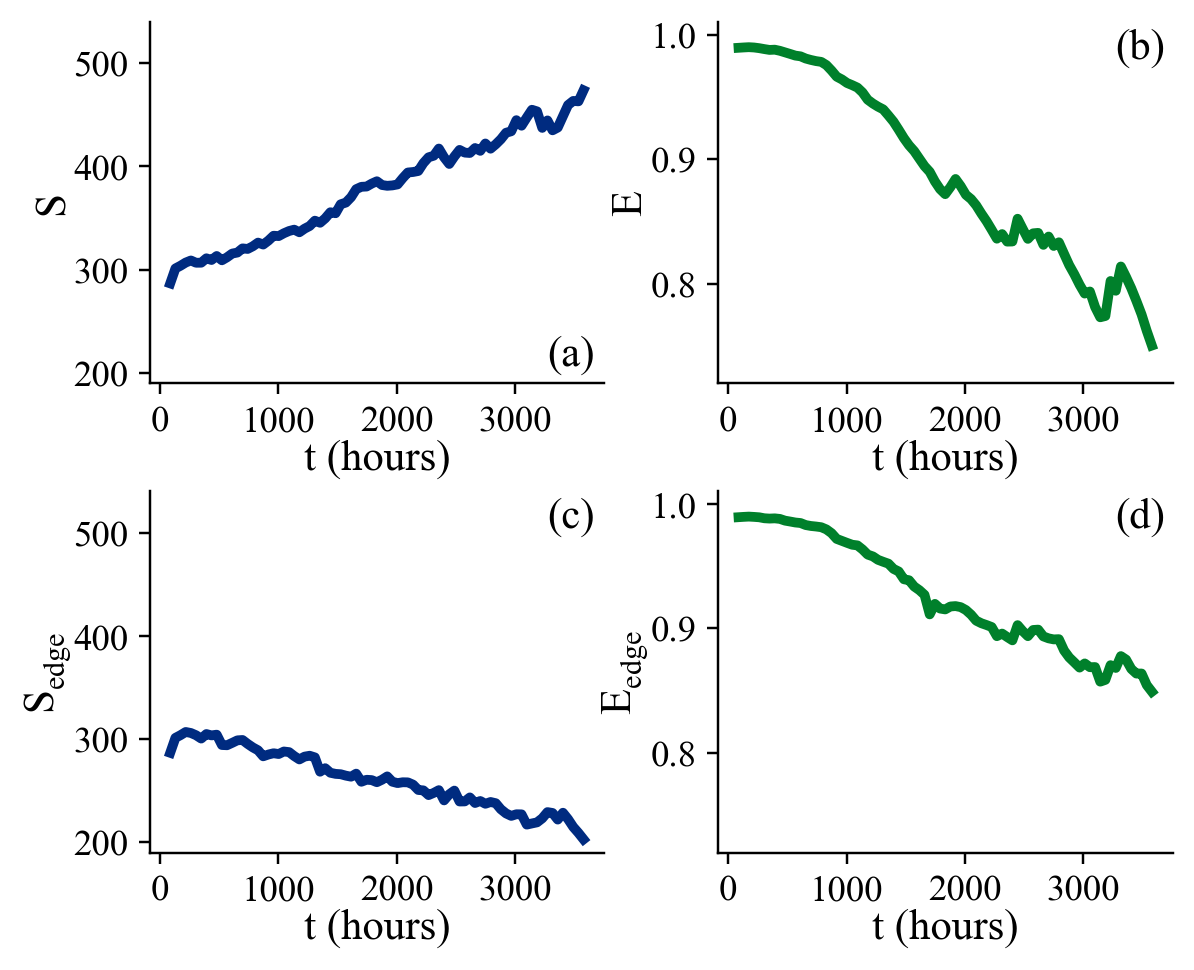

In [57]:
pc_index = 0 #index of the percent resistance (0 = 14%, 1 = 15%, 2 = 16%)
plotGrowthEdgeComparison(t_list_GROWTH[pc_index], [S_list_GROWTH[pc_index], E_list_GROWTH[pc_index]], t_list_GROWTH_EDGE[pc_index], [S_list_GROWTH_EDGE[pc_index], E_list_GROWTH_EDGE[pc_index]])

In [19]:
y_label_list = ["H", "E", "S", "N"]
title_list = ["1", "2", "3", "4"]
shannon_yData_GROWTH = [H_list_GROWTH, E_list_GROWTH, S_list_GROWTH, nBac_list_GROWTH]
shannon_yData_NOGROWTH = [H_list_NOGROWTH, E_list_NOGROWTH, S_list_NOGROWTH, nBac_list_NOGROWTH]
shannon_yData_GROWTH_EDGE = [H_list_GROWTH_EDGE, E_list_GROWTH_EDGE, S_list_GROWTH_EDGE, nBac_list_GROWTH_EDGE]
shannon_yData_GROWTH_CORE = [H_list_GROWTH_CORE, E_list_GROWTH_CORE, S_list_GROWTH_CORE, nBac_list_GROWTH_CORE]

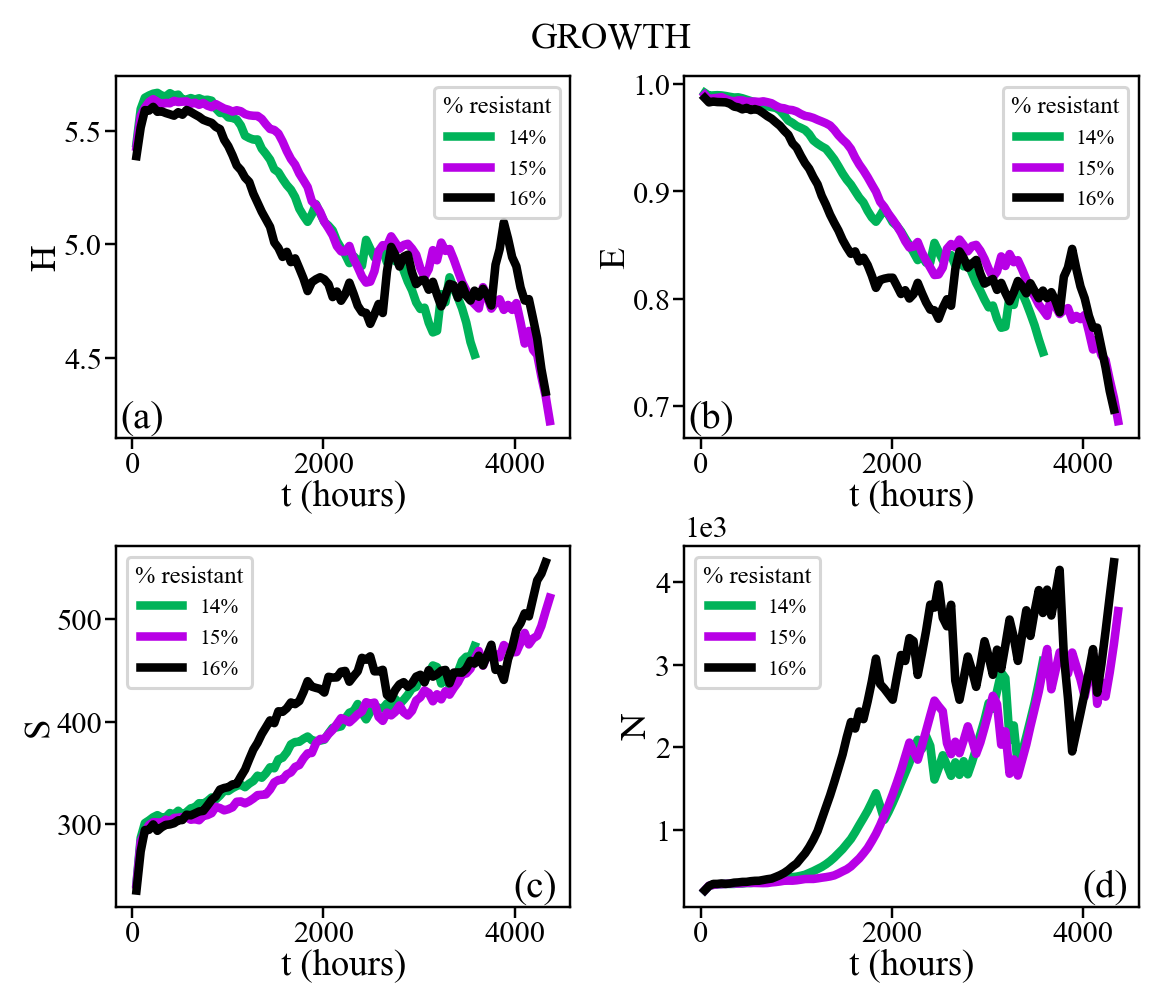

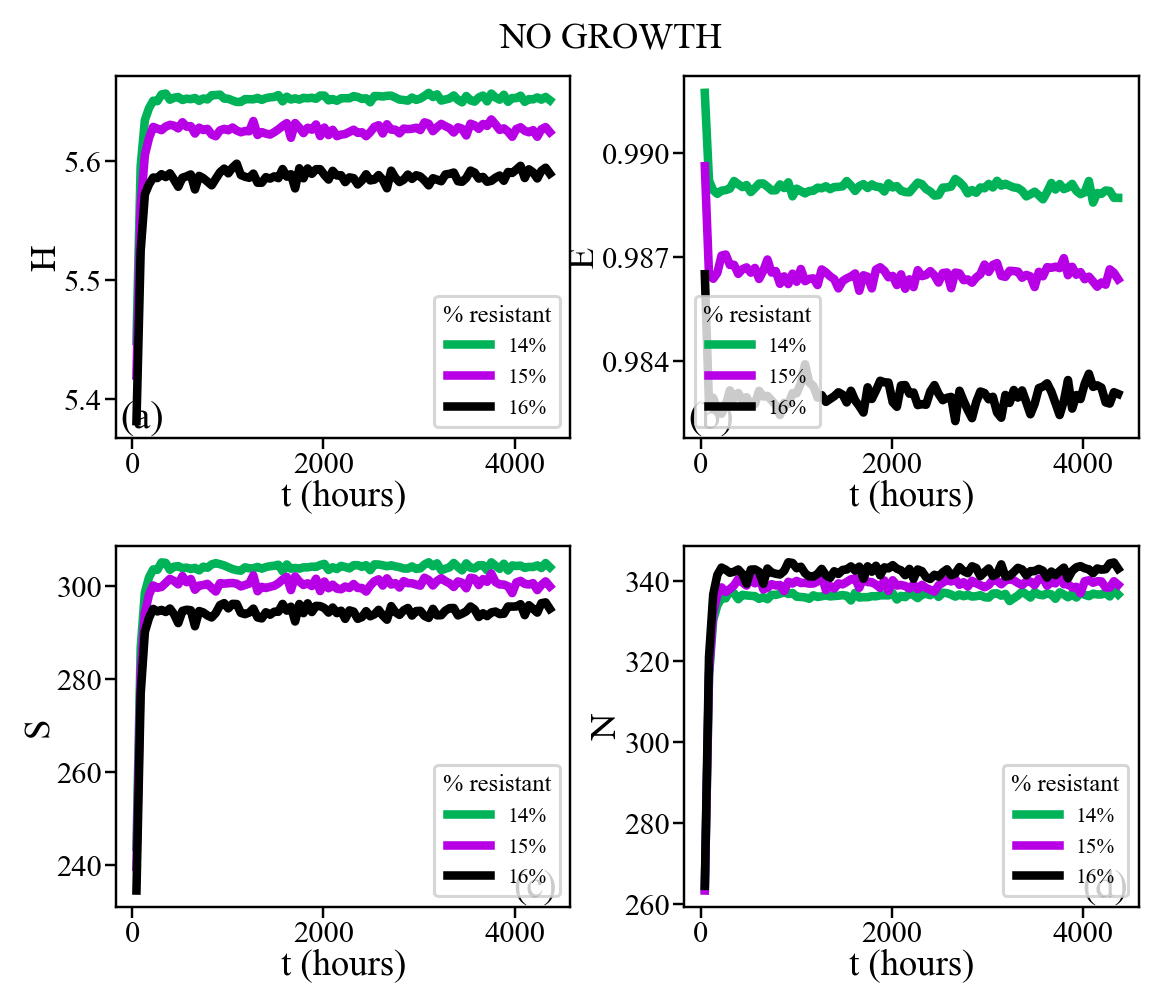

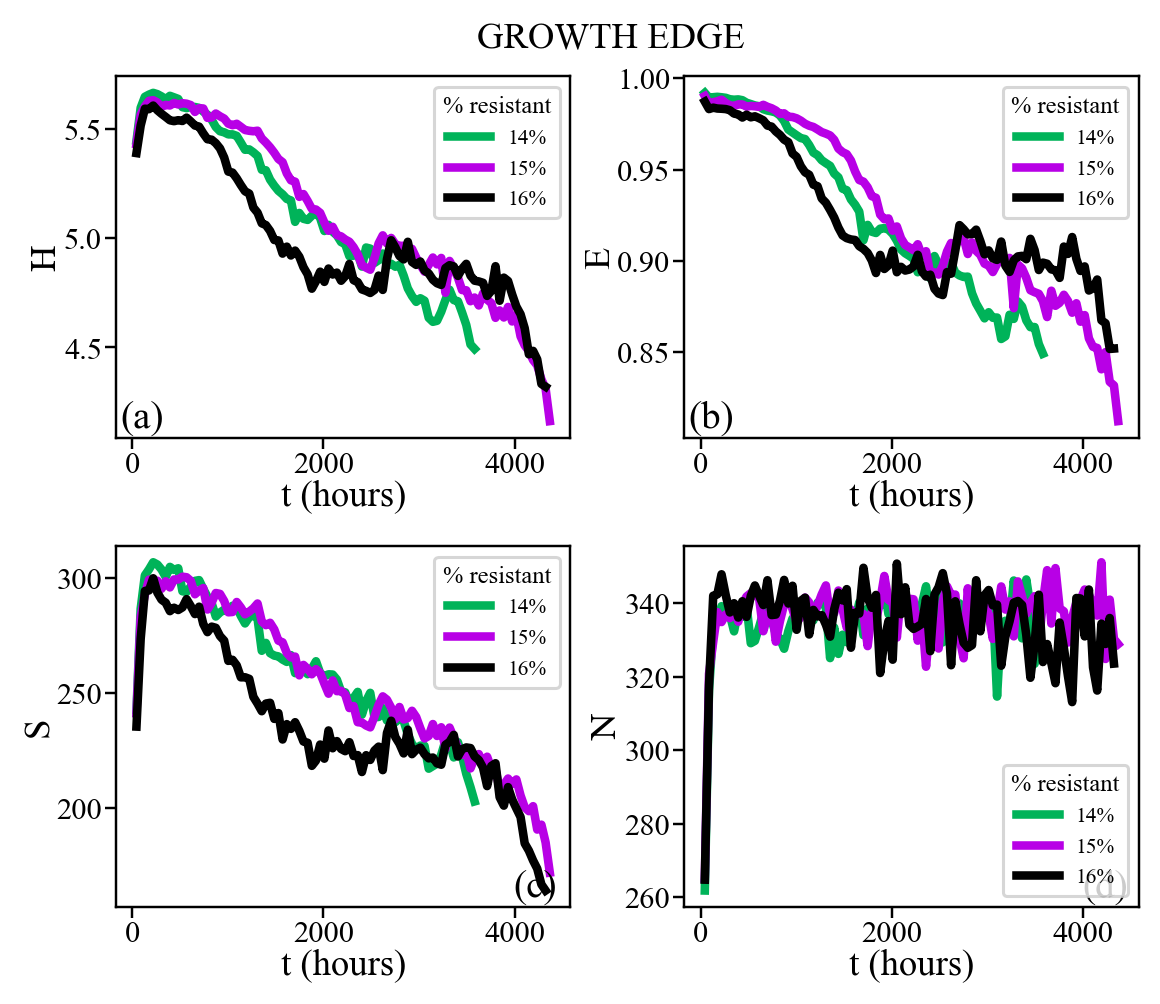

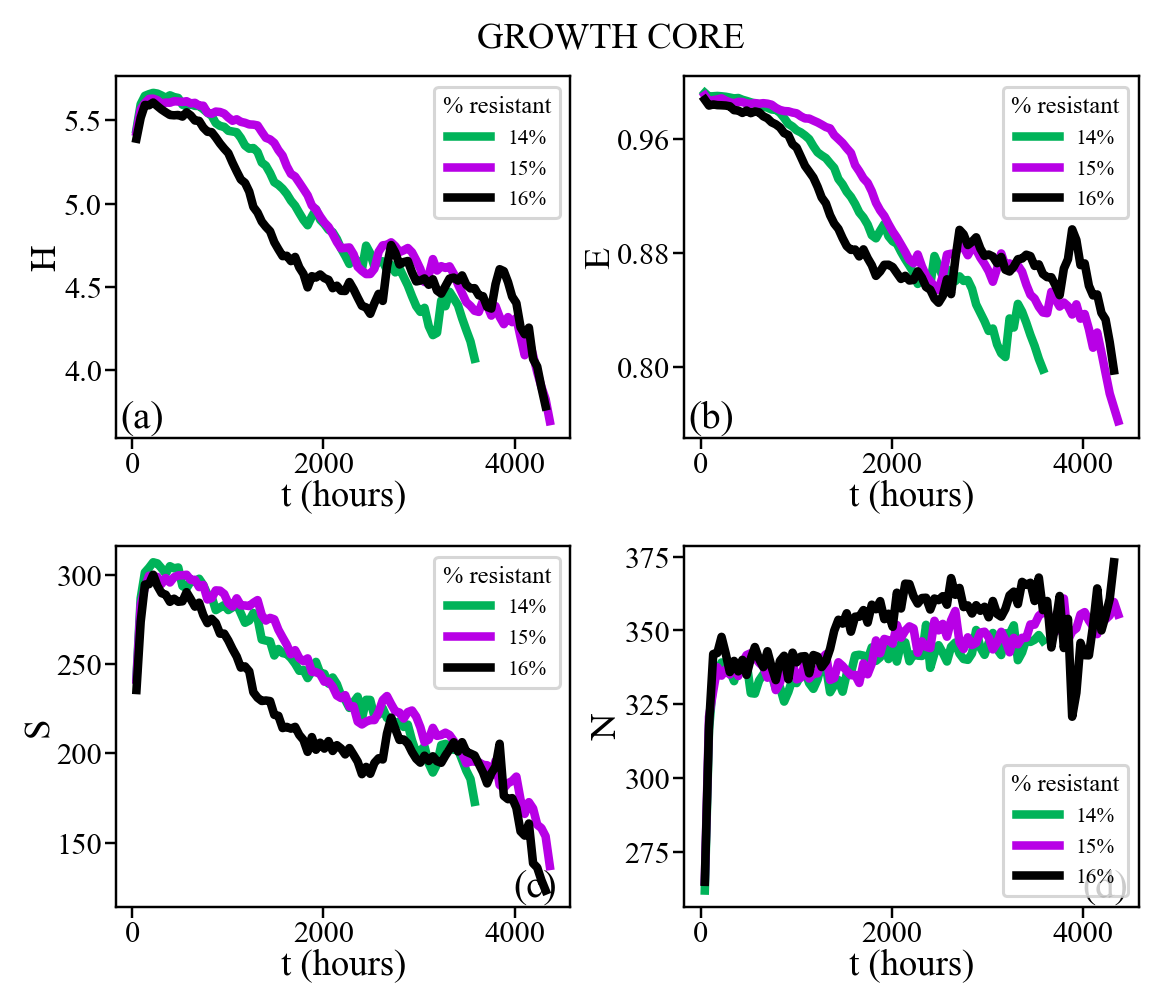

In [20]:
plotPhaseComparisons2x2(t_list_GROWTH, shannon_yData_GROWTH, "t (hours)", y_label_list, title_list, "GROWTH", "2x2_shannonData_vs_t_GROWTH")
plotPhaseComparisons2x2(t_list_NOGROWTH, shannon_yData_NOGROWTH, "t (hours)", y_label_list, title_list, "NO GROWTH", "2x2_shannonData_vs_t_NOGROWTH")
plotPhaseComparisons2x2(t_list_GROWTH_EDGE, shannon_yData_GROWTH_EDGE, "t (hours)", y_label_list, title_list, "GROWTH EDGE", "2x2_shannonData_vs_t_GROWTH_EDGE")
plotPhaseComparisons2x2(t_list_GROWTH_CORE, shannon_yData_GROWTH_CORE, "t (hours)", y_label_list, title_list, "GROWTH CORE", "2x2_shannonData_vs_t_GROWTH_CORE")

In [21]:
# plotPhaseComparisons2x2(nBac_list_GROWTH, shannon_yData_GROWTH, "N", y_label_list, title_list, "GROWTH", "2x2_shannonData_vs_N_GROWTH")
# plotPhaseComparisons2x2(nBac_list_NOGROWTH, shannon_yData_NOGROWTH, "N", y_label_list, title_list, "NO GROWTH", "2x2_shannonData_vs_N_NOGROWTH")
# plotPhaseComparisons2x2(nBac_list_GROWTH_EDGE, shannon_yData_GROWTH_EDGE, "N", y_label_list, title_list, "GROWTH EDGE", "2x2_shannonData_vs_N_GROWTH_EDGE")
# plotPhaseComparisons2x2(nBac_list_GROWTH_CORE, shannon_yData_GROWTH_CORE, "N", y_label_list, title_list, "GROWTH CORE", "2x2_shannonData_vs_N_GROWTH_CORE")

In [22]:
# N_x_list_GROWTH = [np.cumsum(np.array(nBac)) for nBac in nBac_list_GROWTH]
# N_x_list_NOGROWTH = [np.cumsum(np.array(nBac)) for nBac in nBac_list_NOGROWTH]
# N_x_list_GROWTH_EDGE = [np.cumsum(np.array(nBac)) for nBac in nBac_list_GROWTH_EDGE]
# N_x_list_GROWTH_CORE = [np.cumsum(np.array(nBac)) for nBac in nBac_list_GROWTH_CORE]

# plotPhaseComparisons2x2(N_x_list_GROWTH, shannon_yData_GROWTH, "N (cumulative)", y_label_list, title_list, "GROWTH", "2x2_shannonData_vs_N_cumulative_GROWTH")
# plotPhaseComparisons2x2(N_x_list_NOGROWTH, shannon_yData_NOGROWTH, "N (cumulative)", y_label_list, title_list, "NO GROWTH", "2x2_shannonData_vs_N_cumulative_NOGROWTH")
# plotPhaseComparisons2x2(N_x_list_GROWTH_EDGE, shannon_yData_GROWTH_EDGE, "N (cumulative)", y_label_list, title_list, "GROWTH EDGE", "2x2_shannonData_vs_N_cumulative_GROWTH_EDGE")
# plotPhaseComparisons2x2(N_x_list_GROWTH_CORE, shannon_yData_GROWTH_CORE, "N (cumulative)", y_label_list, title_list, "GROWTH CORE", "2x2_shannonData_vs_N_cumulative_GROWTH_CORE")

In [23]:
# #pc_res_14_shannon_data_GROWTH_list = [pc_res_14_24Sep_shannon_data_GROWTH, pc_res_14_09Oct_shannon_data_GROWTH, pc_res_14_14Oct_shannon_data_GROWTH, pc_res_14_06Nov_shannon_data_GROWTH]

# pc_res_14_shannon_data_GROWTH_list_test1 = [pc_res_14_24Sep_shannon_data_GROWTH, pc_res_14_09Oct_shannon_data_GROWTH, pc_res_14_14Oct_shannon_data_GROWTH, pc_res_14_06Nov_shannon_data_GROWTH]

# pc_res_14_shannon_data_GROWTH = collateShannonDicts(pc_res_14_shannon_data_GROWTH_list_test1)

# shannon_data_dict_list_GROWTH_test1 = [pc_res_14_shannon_data_GROWTH]

# t_list_GROWTH_test1, nBac_list_GROWTH_test1, H_list_GROWTH_test1, E_list_GROWTH_test1, S_list_GROWTH_test1 = getAverageAndCollateShannonDataIntoLists(shannon_data_dict_list_GROWTH_test1)

# plotPhaseComparisons(t_list_GROWTH_test1, H_list_GROWTH_test1, pc_res_vals, x_label="t", y_label="H", title_string="H vs t (GROWTH)", filename="H_vs_t_GROWTH.pdf")
# plotPhaseComparisons(t_list_GROWTH_test1, E_list_GROWTH_test1, pc_res_vals, x_label="t", y_label="E", title_string="E vs t (GROWTH)", filename="E_vs_t_GROWTH.pdf")
# plotPhaseComparisons(t_list_GROWTH_test1, S_list_GROWTH_test1, pc_res_vals, x_label="t", y_label="S", title_string="S vs t (GROWTH)", filename="S_vs_t_GROWTH.pdf")
# plotPhaseComparisons(t_list_GROWTH_test1, nBac_list_GROWTH_test1, pc_res_vals, x_label="t", y_label="N", title_string="N vs t (GROWTH)", filename="N_vs_t_GROWTH.pdf")


In [24]:
# plotPhaseComparisons(t_list, H_list, pc_res_vals, x_label="t", y_label="H", title_string="H vs t", filename="H_vs_t.pdf")
# plotPhaseComparisons(t_list, E_list, pc_res_vals, x_label="t", y_label="E", title_string="E vs t", filename="E_vs_t.pdf")
# plotPhaseComparisons(t_list, S_list, pc_res_vals, x_label="t", y_label="S", title_string="S vs t", filename="S_vs_t.pdf")
# plotPhaseComparisons(t_list, nBac_list, pc_res_vals, x_label="t", y_label="N", title_string="N vs t", filename="N_vs_t.pdf")

In [25]:
# plotPhaseComparisons(t_list_GROWTH, H_list_GROWTH, pc_res_vals, x_label="t", y_label="H", title_string="H vs t (GROWTH)", filename="H_vs_t_GROWTH.pdf")
# plotPhaseComparisons(t_list_GROWTH, E_list_GROWTH, pc_res_vals, x_label="t", y_label="E", title_string="E vs t (GROWTH)", filename="E_vs_t_GROWTH.pdf")
# plotPhaseComparisons(t_list_GROWTH, S_list_GROWTH, pc_res_vals, x_label="t", y_label="S", title_string="S vs t (GROWTH)", filename="S_vs_t_GROWTH.pdf")
# plotPhaseComparisons(t_list_GROWTH, nBac_list_GROWTH, pc_res_vals, x_label="t", y_label="N", title_string="N vs t (GROWTH)", filename="N_vs_t_GROWTH.pdf")

In [26]:
# plotPhaseComparisons(t_list_NOGROWTH, H_list_NOGROWTH, pc_res_vals, x_label="t", y_label="H", title_string="H vs t (NO GROWTH)", filename="H_vs_t_NOGROWTH.pdf")
# plotPhaseComparisons(t_list_NOGROWTH, E_list_NOGROWTH, pc_res_vals, x_label="t", y_label="E", title_string="E vs t (NO GROWTH)", filename="E_vs_t_NOGROWTH.pdf")
# plotPhaseComparisons(t_list_NOGROWTH, S_list_NOGROWTH, pc_res_vals, x_label="t", y_label="S", title_string="S vs t (NO GROWTH)", filename="S_vs_t_NOGROWTH.pdf")
# plotPhaseComparisons(t_list_NOGROWTH, nBac_list_NOGROWTH, pc_res_vals, x_label="t", y_label="N", title_string="N vs t (NO GROWTH)", filename="N_vs_t_NOGROWTH.pdf")

In [27]:
# plotPhaseComparisons(t_list_GROWTH_EDGE, H_list_GROWTH_EDGE, pc_res_vals, x_label="t", y_label="H", title_string="H vs t (GROWTH, EDGE)", filename="H_vs_t_GROWTH_EDGE.pdf")
# plotPhaseComparisons(t_list_GROWTH_EDGE, E_list_GROWTH_EDGE, pc_res_vals, x_label="t", y_label="E", title_string="E vs t (GROWTH, EDGE)", filename="E_vs_t_GROWTH_EDGE.pdf")
# plotPhaseComparisons(t_list_GROWTH_EDGE, S_list_GROWTH_EDGE, pc_res_vals, x_label="t", y_label="S", title_string="S vs t (GROWTH, EDGE)", filename="S_vs_t_GROWTH_EDGE.pdf")
# plotPhaseComparisons(t_list_GROWTH_EDGE, nBac_list_GROWTH_EDGE, pc_res_vals, x_label="t", y_label="N", title_string="N vs t (GROWTH, EDGE)", filename="N_vs_t_GROWTH_EDGE.pdf")

In [28]:
# N_x_list = [np.cumsum(np.array(n)) for n in nBac_list_GROWTH_EDGE]
# plotPhaseComparisons(N_x_list, H_list_GROWTH_EDGE, pc_res_vals, x_label="N (cumulative)", y_label="H", title_string="H vs N (GROWTH, EDGE)", filename="H_vs_N_GROWTH_EDGE.pdf")
# plotPhaseComparisons(N_x_list, E_list_GROWTH_EDGE, pc_res_vals, x_label="N (cumulative)", y_label="E", title_string="E vs N (GROWTH, EDGE)", filename="E_vs_N_GROWTH_EDGE.pdf")
# plotPhaseComparisons(N_x_list, S_list_GROWTH_EDGE, pc_res_vals, x_label="N (cumulative)", y_label="S", title_string="S vs N (GROWTH, EDGE)", filename="S_vs_N_GROWTH_EDGE.pdf")
# plotPhaseComparisons(N_x_list, nBac_list_GROWTH_EDGE, pc_res_vals, x_label="N (cumulative)", y_label="N", title_string="N vs N (GROWTH, EDGE)", filename="N_vs_N_GROWTH_EDGE.pdf")

In [29]:
# N_x_list = [np.cumsum(np.array(n)) for n in nBac_list_GROWTH]
# plotPhaseComparisons(N_x_list, H_list_GROWTH, pc_res_vals, x_label="N (cumulative)", y_label="H", title_string="H vs N (GROWTH)", filename="H_vs_N_GROWTH.pdf")
# plotPhaseComparisons(N_x_list, E_list_GROWTH, pc_res_vals, x_label="N (cumulative)", y_label="E", title_string="E vs N (GROWTH)", filename="E_vs_N_GROWTH.pdf")
# plotPhaseComparisons(N_x_list, S_list_GROWTH, pc_res_vals, x_label="N (cumulative)", y_label="S", title_string="S vs N (GROWTH)", filename="S_vs_N_GROWTH.pdf")
# plotPhaseComparisons(N_x_list, nBac_list_GROWTH, pc_res_vals, x_label="N (cumulative)", y_label="N", title_string="N vs N (GROWTH)", filename="N_vs_N_GROWTH.pdf")